In [2]:
import os
import time
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
#from yellowbrick.classifier import ConfusionMatrix
from sklearn.metrics import precision_recall_fscore_support as score

In [3]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve, average_precision_score, precision_score, recall_score
from sklearn.metrics import plot_roc_curve

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
#from google.colab import drive
#drive.mount('/content/gdrive')

In [6]:
df = pd.read_csv('datasetforclassification.csv', engine='python',usecols=['Base_Reviews','My_Labels'])
df = df[pd.notnull(df['My_Labels'])]
print(df.head())
print(df['Base_Reviews'].astype(str).apply(lambda x: len(x.split(' '))).sum())
df.groupby('My_Labels').count()

  My_Labels                                       Base_Reviews
0   sadness  I am crying . Bought and paid the app.and don'...
1     anger  downloaded and deleted because I faces problem...
2   sadness  From some time the app shows invalid file when...
3   disgust  You can only make calls to users of this app.I...
4   disgust  I couldn't even sign up it just exited out and...
212825


,Base_Reviews
My_Labels,
anger,1562
disgust,785
fear,2729
sadness,1923


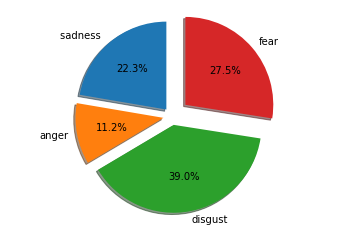

In [57]:
labels  = My_Labels = 'sadness ','anger','disgust','fear'
sizes =[1562,785,2729,1923]
explode =(0.1,0.1,0.1,0.2) 
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels =labels , autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

## clean_text
clean the text by removing special characters, punctuations, etc.

In [8]:
# Text Pre-processing (text cleaning techniques)
from bs4 import BeautifulSoup
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nekdil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
def print_plot(index):
    example = df[df.index == index][['Base_Reviews', 'My_Labels']].values[0]
    if len(example) > 0:
        print(example[0])
        print('My_Labels:', example[1])
print_plot(1)

downloaded and deleted because I faces problem in the dificult  layout. And also I got problem like this " invalid file when trying to open". Can you please fix this. Bothering me bro
My_Labels: anger


In [10]:
# We want to show a look a Clean text and lables as you wanna.(After text_Preprocessing)
df['Base_Reviews'] = df['Base_Reviews'].astype(str).apply(clean_text)
print_plot(1) # 4567

downloaded deleted faces problem dificult layout also got problem like invalid file trying open please fix bothering bro
My_Labels: anger


In [11]:
def clean_text(text):
    """ clean the text by removing special characters, punctuations, etc. """
    text = text.lower()
    remove_xx_seq  = re.compile('xx+')
    replace_by_space = re.compile('[/(){}\[\]\|@,;]')
    remove_special_characters = re.compile('[^0-9a-z +]')
    remove_extra_space = re.compile('[^A-Za-z0-9]+')
    remove_numbers = re.compile('[0-9]+')
    text = re.sub(remove_xx_seq, ' ', text)
    text = re.sub(replace_by_space, ' ', text)
    text = re.sub(remove_special_characters, ' ', text)
    text = re.sub(remove_numbers, ' ', text)
    text = re.sub(remove_extra_space, ' ', text)
    return text.strip()

## preprocess_corpus
Preprocess the entire corpus including cleaning the text documents and return the updated dataframe.

In [12]:
def preprocess_corpus(df, column='text'):
    """ Preprocess the entire corpus including cleaning the text documents and return the updated dataframe. """
    df[column] = df[column].apply(clean_text)
    return df

## Encode_labels
Encode the class labels into a numbers.

In [13]:
def encode_labels(labels):
    """ Encode the class labels into a numbers. """
    label_encoder = preprocessing.LabelEncoder()
    label_encoder.fit(labels)
    #label_encoder.get_vocabulary()
    return label_encoder


## Compute_tfidf
 Calculate the tfidf features for all the text documents and return a (documents, fatures) matrix. 

In [14]:
# def compute_tfidf(corpus, stop_words='english', ngram_range=(1, 1), max_features=None):
  #   """ Calculate the tfidf features for all the text documents and return a (documents, fatures) matrix. """
   #  vectorizer = TfidfVectorizer(input='content', stop_words=stop_words, ngram_range=ngram_range, min_df=3, max_df=0.9, max_features=max_features)
   ##  print('Computing tfidf features...', end='')
    # X = vectorizer.fit_transform(corpus)
   #  print('done!')
    # return X, vectorizer

## Count Vectorizer

In [15]:
 def compute_count(corpus, stop_words='english', ngram_range=(1, 1), max_features=None):
     """ Calculate the Count Vectorizer features for all the text documents and return a (documents, fatures) matrix. """
     vectorizer = CountVectorizer(input='content', stop_words=stop_words, ngram_range=ngram_range, min_df=3, max_df=0.9, max_features=max_features)
     print('Computing tfidf features...', end='')
     X = vectorizer.fit_transform(corpus)
     print('done!')
     return X, vectorizer

## Train_test_model
Train and test the model using the training and test data sets. Return the predictions, accuracy and metric reports.

In [16]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
alg_accuracy= []
alg_p_r_f_score =[]

def train_test_model(model, X_train, X_test, y_train, y_test,labels):
    """ Train and test the model using the training and test data sets. Return the predictions, accuracy and metric reports. """
    print('Start training...', end='')
    model.fit(X_train, y_train)
    print('done!')
    print('Start testing...', end='')
    predictions = model.predict(X_test)
    accuracy = model.score(X_test, y_test)
    ####javed####
    alg_accuracy= accuracy_score(predictions, y_test)
    alg_p_r_f_score = precision_recall_fscore_support(y_test,predictions, average=None)
     ####javed####
    f1score = f1_score(y_test, predictions, average='weighted', pos_label=4)
    confusionMatrix = confusion_matrix(y_test, predictions)
    recall = recall_score(y_test, predictions, average='weighted', pos_label=4)
    precision = precision_score(y_test, predictions, average='weighted', pos_label=4)
    metrics_report = classification_report(y_test, predictions, target_names=labels)
#    precision, recall, fscore, train_support = score(y_test, predictions, average='weighted')
    print('done!')
    return predictions, accuracy, precision, recall, f1score, alg_accuracy, alg_p_r_f_score
    #return  predictions, accuracy, tpr, fpr

Number of categories:  ['sadness' 'anger' 'disgust' 'fear']



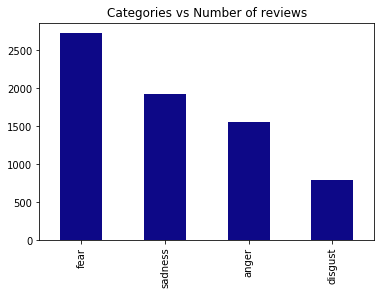

In [17]:
categories = df.My_Labels.unique()
print('Number of categories: ', categories)
print()
df.My_Labels.value_counts().plot(kind='bar', title='Categories vs Number of reviews', cmap='plasma')

# Setting for model TFIDF Features

In [18]:
# Create tfidf features from the text
stop_words    = 'english'
ngram_range   = (1, 1)
max_features  = None
# X, vectorizer = compute_tfidf(df['Base_Reviews'].apply(lambda x: np.str_(x)), stop_words, ngram_range, max_features)
X, vectorizer = compute_count(df['Base_Reviews'].apply(lambda x: np.str_(x)), stop_words, ngram_range, max_features)

# Encode the labels
labels = df.My_Labels.unique()
label_encoder = encode_labels(labels)
y = label_encoder.transform(df.My_Labels)
print(X)
print(vectorizer)
print(y)

Computing tfidf features...done!
  (0, 888)	1
  (0, 507)	1
  (0, 2408)	1
  (0, 294)	1
  (0, 1069)	1
  (0, 3821)	2
  (0, 1879)	1
  (0, 1607)	1
  (0, 12)	1
  (0, 3478)	1
  (0, 290)	2
  (0, 3067)	1
  (0, 1796)	1
  (0, 1338)	1
  (0, 3548)	1
  (0, 2354)	1
  (0, 2440)	1
  (0, 3656)	1
  (0, 2044)	1
  (0, 2774)	1
  (0, 1653)	1
  (0, 1365)	1
  (0, 2609)	1
  (0, 1062)	1
  (1, 1796)	1
  :	:
  (6995, 3274)	1
  (6996, 2069)	1
  (6996, 2922)	1
  (6996, 2716)	1
  (6996, 3156)	1
  (6996, 3202)	1
  (6996, 3007)	1
  (6996, 1168)	1
  (6996, 3641)	1
  (6996, 3013)	1
  (6996, 617)	1
  (6996, 2098)	1
  (6996, 2567)	1
  (6996, 1506)	1
  (6997, 3478)	1
  (6997, 1600)	1
  (6997, 2510)	1
  (6997, 3724)	1
  (6997, 779)	1
  (6997, 2925)	1
  (6998, 1069)	1
  (6998, 1301)	1
  (6998, 1977)	1
  (6998, 2722)	1
  (6998, 2433)	1
CountVectorizer(max_df=0.9, min_df=3, stop_words='english')
[3 0 3 ... 2 2 1]


## Import Oversampling and Under-sampling methods

In [19]:
!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_val_score
sm = SMOTE()
rus = RandomUnderSampler(random_state=42, replacement=True)# fit predictor and target variable

In [20]:
skfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)

# Oversampling

### MultinomialNB

Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Total time: 4.84s
mean accuracy: 0.77 %
mean f1 socre: 0.77 %
mean precision: 0.78 %
mean recall: 0.77 %
the average accuracy of MNB is 0.7669673002248111
the presion, recall, f are [[  0.74411673   0.6725506    0.8794944    0.72162293]
 [  0.76441287   0.87776696   0.69621983   0.8242093 ]
 [  0.75366544   0.76030141   0.77680878   0.76862532]
 [156.2         78.5        272.9        192.3       ]]
0.9193552746723703
[(0, 2457), (1, 2457), (2, 2457), (3, 2457)]


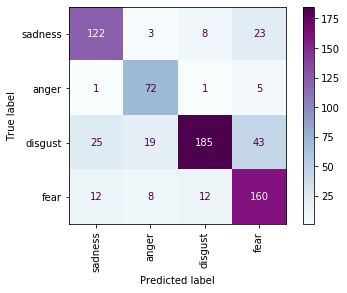

In [21]:
from scipy import interp
nb_model = MultinomialNB()

accs = []
reports = []
f1 = []
pr = []
re = []
pe = []
#javed#
accuracy_ = []
P_r_f = []

mean_accuracy= []
mean_p_r_f =[]
##javed###
roc_auc_ = []
roc_auc_one = []
roc_auc_two = []
roc_auc_three = []
#n1 roc_auc_four = []

tprs_zero_nb = []
tprs_one_nb = []
tprs_two_nb = []
tprs_three_nb = []
#n1 tprs_four_nb = []

mean_fpr = np.linspace(0,1,100)

st_time = time.time()
for train_index, test_index in skfold.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # Oversample
    X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
    predictions, accuracy, precision, recall, f1socre,alg_accuracy, alg_p_r_f_score  = train_test_model(nb_model, X_train_res, X_test, y_train_res, y_test, labels)
    #print("the accuracy is",alg_accuracy)
    #break
   # fpr_zero, tpr_zero, _ = roc_curve(y_test, nb_model.predict_proba(X_test)[:,1], pos_label=0)
    fpr_one, tpr_one, __ = roc_curve(y_test, nb_model.predict_proba(X_test)[:,3], pos_label=3)
    #fpr_two, tpr_two, ___ = roc_curve(y_test, nb_model.predict_proba(X_test)[:,1], pos_label=2)
    #fpr_three, tpr_three, ____ = roc_curve(y_test, nb_model.predict_proba(X_test)[:,1], pos_label=3)
    #fpr_four, tpr_four, _____ = roc_curve(y_test, nb_model.predict_proba(X_test)[:,1], pos_label=4)
    
    tprs_one_nb.append(interp(mean_fpr, fpr_one, tpr_one))
    
    #roc_auc_one = (auc(fpr_zero, tpr_zero))
    roc_auc_one = (auc(fpr_one, tpr_one))
    #roc_auc_two = (auc(fpr_two, tpr_two))
    #roc_auc_three = (auc(fpr_three, tpr_three))
    #roc_auc_four = (auc(fpr_four, tpr_four))
    
    #javed###      
    accuracy_.append(alg_accuracy)
    P_r_f.append(alg_p_r_f_score)
    #### jave ####

    pe.append(predictions)
    accs.append(accuracy)
    f1.append(f1socre)
    pr.append(precision)
    re.append(recall)
      
en_time = time.time()
#print('mean predictions: {:.2f} %'.format(sum(pe) / len(pe) ))
print('Total time: {:.2f}s'.format(en_time-st_time))   
print('mean accuracy: {:.2f} %'.format(np.mean(accs)))
print('mean f1 socre: {:.2f} %'.format(np.mean(f1)))
print('mean precision: {:.2f} %'.format(np.mean(pr)))
print('mean recall: {:.2f} %'.format(np.mean(re)))

#roc_zero = sum(roc_auc_) / len(roc_auc_)
#print("\nROC across folds for zero: ", roc_zero)

#roc_one = sum(roc_auc_one) / len(roc_auc_one)
#print("\nROC across folds for one: ", roc_one)

#roc_two = sum(roc_auc_two) / len(roc_auc_two)
#print("\nROC across folds for two: ", roc_two)

#roc_three = sum(roc_auc_three) / len(roc_auc_three)
#print("\nROC across folds for three: ", roc_three)

#roc_four = sum(roc_auc_four) / len(roc_auc_four)
#print("\nROC across folds for four: ", roc_four)

mean_tpr = np.mean(tprs_one_nb, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)

#### jave ####
mean_accuracy= np.mean(accuracy_, axis=0)
print("the average accuracy of MNB is",mean_accuracy)
    
mean_p_r_f=np.mean(P_r_f, axis=0)
print("the presion, recall, f are", mean_p_r_f)
#### jave ####

#print(mean_tpr)
#print(mean_fpr)
print(mean_auc)
#print(metrics_report)
unique, counts = np.unique(y_train_res, return_counts=True)
print(list(zip(unique, counts)))
plot_confusion_matrix(nb_model, X_test, y_test, display_labels=labels, xticks_rotation='vertical', cmap="BuPu")

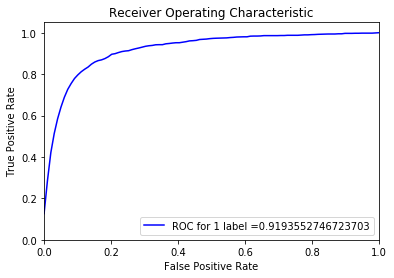

In [22]:
plt.title('Receiver Operating Characteristic')
#plt.plot(fpr_zero, tpr_zero, 'b', color='green', label= "ROC for 0 label =" +str(roc_zero))
plt.plot(mean_fpr, mean_tpr, 'b', label= "ROC for 1 label =" +str(mean_auc))
#plt.plot(fpr_two, tpr_two, 'b', color='purple',  label= "ROC for 2 label =" +str(roc_two))
#plt.plot(fpr_three, tpr_three, 'b', color='red',  label= "ROC for 3 label =" +str(roc_three))
#plt.plot(fpr_four, tpr_four, 'b', color='yellow', label= "ROC for 4 label =" +str(roc_four))
plt.legend(loc = 'lower right')
#plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### LogisticRegression

Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Total time: 18.45s
mean accuracy: 0.93 %
mean f1 socre: 0.93 %
mean precision: 0.93 %
mean recall: 0.93 %

ROC across folds for zero:  0.39758636898290434

ROC across folds for one:  0.9983114351487655

ROC across folds for two:  0.41629818541540187

ROC across folds for three:  0.4400205836871457

ROC across folds for four:  nan
the average accuracy of LR is 0.9334185571224198
the presion, recall, f are [[  0.92385939   0.97900033   0.93190903   0.92747513]
 [  0.91166095   0.93370659   0.9490654    0.92874028]
 [  0.91732517   0.9555159    0.

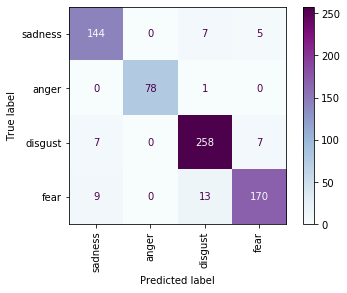

In [23]:
log_model = LogisticRegression(penalty='l2', max_iter=500)

accs = []
reports = []
f1 = []
pr = []
re = []
pe = []

#javed#
accuracy_ = []
P_r_f = []

mean_accuracy= []
mean_p_r_f =[]
##javed###

roc_auc_ = []
roc_auc_one = []
roc_auc_two = []
roc_auc_three = []
roc_auc_four = []
st_time = time.time()
for train_index, test_index in skfold.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # Oversample
    #X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
    predictions, accuracy, precision, recall, f1socre, alg_accuracy, alg_p_r_f_score = train_test_model(log_model, X_train, X_test, y_train, y_test, labels)
    
    fpr_zero, tpr_zero, _ = roc_curve(y_test, log_model.predict_proba(X_test)[:,1], pos_label=0)
    fpr_one, tpr_one, __ = roc_curve(y_test, log_model.predict_proba(X_test)[:,1], pos_label=1)
    fpr_two, tpr_two, ___ = roc_curve(y_test, log_model.predict_proba(X_test)[:,1], pos_label=2)
    fpr_three, tpr_three, ____ = roc_curve(y_test, log_model.predict_proba(X_test)[:,1], pos_label=3)
    fpr_four, tpr_four, _____ = roc_curve(y_test, log_model.predict_proba(X_test)[:,1], pos_label=4)

    roc_auc_.append(auc(fpr_zero, tpr_zero))
    roc_auc_one.append(auc(fpr_one, tpr_one))
    roc_auc_two.append(auc(fpr_two, tpr_two))
    roc_auc_three.append(auc(fpr_three, tpr_three))
    roc_auc_four.append(auc(fpr_four, tpr_four))
    
     #javed###      
    accuracy_.append(alg_accuracy)
    P_r_f.append(alg_p_r_f_score)
    #### jave ####

    pe.append(predictions)
    accs.append(accuracy)
    f1.append(f1socre)
    pr.append(precision)
    re.append(recall)


en_time = time.time()
#print('mean predictions: {:.2f} %'.format(sum(pe) / len(pe) ))
print('Total time: {:.2f}s'.format(en_time-st_time))   
print('mean accuracy: {:.2f} %'.format(np.mean(accs)))
print('mean f1 socre: {:.2f} %'.format(np.mean(f1)))
print('mean precision: {:.2f} %'.format(np.mean(pr)))
print('mean recall: {:.2f} %'.format(np.mean(re)))

roc_zero = sum(roc_auc_) / len(roc_auc_)
print("\nROC across folds for zero: ", roc_zero)

roc_one = sum(roc_auc_one) / len(roc_auc_one)
print("\nROC across folds for one: ", roc_one)

roc_two = sum(roc_auc_two) / len(roc_auc_two)
print("\nROC across folds for two: ", roc_two)

roc_three = sum(roc_auc_three) / len(roc_auc_three)
print("\nROC across folds for three: ", roc_three)

roc_four = sum(roc_auc_four) / len(roc_auc_four)
print("\nROC across folds for four: ", roc_four)

#### jave ####
mean_accuracy= np.mean(accuracy_, axis=0)
print("the average accuracy of LR is",mean_accuracy)
    
mean_p_r_f=np.mean(P_r_f, axis=0)
print("the presion, recall, f are", mean_p_r_f)
#### jave ####


#print(fpr_zero)
#print(tpr_zero)

#print(metrics_report)
unique, counts = np.unique(y_train, return_counts=True)
print(list(zip(unique, counts)))
plot_confusion_matrix(log_model, X_test, y_test, display_labels=labels, xticks_rotation='vertical', cmap="BuPu")

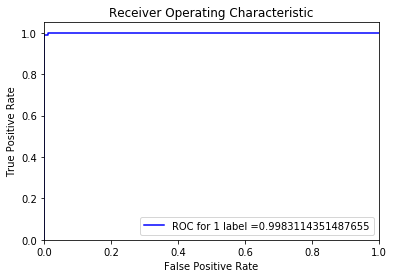

In [24]:
plt.title('Receiver Operating Characteristic')
#plt.plot(fpr_zero, tpr_zero, 'b', color='green', label= "ROC for 0 label =" +str(roc_zero))
plt.plot(fpr_one, tpr_one, 'b', label= "ROC for 1 label =" +str(roc_one))
#plt.plot(fpr_two, tpr_two, 'b', color='purple',  label= "ROC for 2 label =" +str(roc_two))
#plt.plot(fpr_three, tpr_three, 'b', color='red',  label= "ROC for 3 label =" +str(roc_three))
#plt.plot(fpr_four, tpr_four, 'b', color='yellow', label= "ROC for 4 label =" +str(roc_four))
plt.legend(loc = 'lower right')
#plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### LinearSVC

Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Total time: 16.78s
mean accuracy: 0.94 %
mean f1 socre: 0.94 %
mean precision: 0.94 %
mean recall: 0.94 %
the average accuracy of LSV is 0.9394140609033312
the presion, recall, f are [[  0.91613624   0.92142621   0.97051472   0.92648544]
 [  0.9506941    0.99490425   0.91606739   0.94070056]
 [  0.93291539   0.95661985   0.94239376   0.93336892]
 [156.2         78.5        272.9        192.3       ]]
[(0, 2457), (1, 2457), (2, 2457), (3, 2457)]


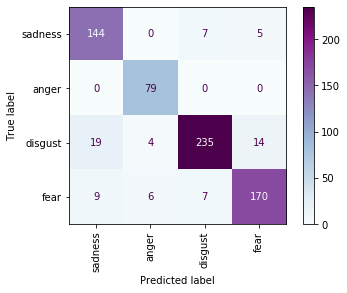

In [25]:
svm = LinearSVC(class_weight='balanced', verbose=False, max_iter=10000, tol=1e-4, C=0.1)

accs = []
reports = []
f1 = []
pr = []
re = []
pe = []

#javed#
accuracy_ = []
P_r_f = []

mean_accuracy= []
mean_p_r_f =[]
##javed###

roc_auc_ = []
roc_auc_one = []
roc_auc_two = []
roc_auc_three = []
roc_auc_four_svm = []

tprs_zero_svm = []
tprs_one_svm = []
tprs_two_svm = []
tprs_three_svm = []
tprs_four_svm = []

mean_fpr_svm = np.linspace(0,1,100)

st_time = time.time()
for train_index, test_index in skfold.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # Oversample
    #X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
    predictions, accuracy, precision, recall, f1socre, alg_accuracy, alg_p_r_f_score = train_test_model(svm, X_train_res, X_test, y_train_res, y_test, labels)
    
    #fpr_zero, tpr_zero, _ = roc_curve(y_test, svm.decision_function(X_test)[:,1], pos_label=0)
    #fpr_one, tpr_one, __ = roc_curve(y_test, svm.decision_function(X_test)[:,1], pos_label=1)
    #fpr_two, tpr_two, ___ = roc_curve(y_test, svm.decision_function(X_test)[:,1], pos_label=2)
    #fpr_three, tpr_three, ____ = roc_curve(y_test, svm.decision_function(X_test)[:,1], pos_label=3)
    fpr_four_svm, tpr_four_svm, _____ = roc_curve(y_test, svm.decision_function (X_test)[:,3], pos_label=3)

    tprs_four_svm.append(interp(mean_fpr_svm, fpr_four_svm, tpr_four_svm))
    
    #roc_auc_one = (auc(fpr_zero, tpr_zero))
    #roc_auc_one = (auc(fpr_one, tpr_one))
    #roc_auc_two = (auc(fpr_two, tpr_two))
    #roc_auc_three = (auc(fpr_three, tpr_three))
    roc_auc_four = (auc(fpr_four_svm, tpr_four_svm))
    
    
     #javed###      
    accuracy_.append(alg_accuracy)
    P_r_f.append(alg_p_r_f_score)
    #### jave ####

    pe.append(predictions)
    accs.append(accuracy)
    f1.append(f1socre)
    pr.append(precision)
    re.append(recall)


en_time = time.time()
#print('mean predictions: {:.2f} %'.format(sum(pe) / len(pe) ))
print('Total time: {:.2f}s'.format(en_time-st_time))   
print('mean accuracy: {:.2f} %'.format(np.mean(accs)))
print('mean f1 socre: {:.2f} %'.format(np.mean(f1)))
print('mean precision: {:.2f} %'.format(np.mean(pr)))
print('mean recall: {:.2f} %'.format(np.mean(re)))

#roc_zero = sum(roc_auc_) / len(roc_auc_)
#print("\nROC across folds for zero: ", roc_zero)

#roc_one = sum(roc_auc_one) / len(roc_auc_one)
#print("\nROC across folds for one: ", roc_one)

#roc_two = sum(roc_auc_two) / len(roc_auc_two)
#print("\nROC across folds for two: ", roc_two)

#roc_three = sum(roc_auc_three) / len(roc_auc_three)
#print("\nROC across folds for three: ", roc_three)

#roc_four_svm = sum(roc_auc_four_svm) / len(roc_auc_four_svm)
#print("\nROC across folds for four: ", roc_four_svm)

#### jave ####
mean_accuracy= np.mean(accuracy_, axis=0)
print("the average accuracy of LSV is",mean_accuracy)
    
mean_p_r_f=np.mean(P_r_f, axis=0)
print("the presion, recall, f are", mean_p_r_f)
#### jave ####

mean_tpr_svm = np.mean(tprs_four_svm, axis=0)
mean_auc_svm = auc(mean_fpr_svm, mean_tpr_svm)

#print(mean_tpr_svm)
#print(mean_fpr_svm)
#print(mean_auc_svm)

#print(metrics_report)
unique, counts = np.unique(y_train_res, return_counts=True)
print(list(zip(unique, counts)))
plot_confusion_matrix(svm, X_test, y_test, display_labels=labels, xticks_rotation='vertical', cmap="BuPu")

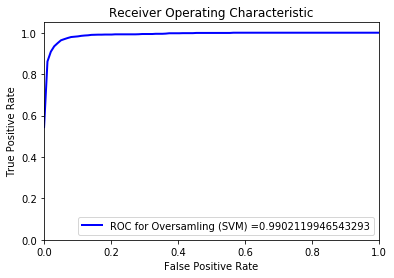

In [26]:
plt.title('Receiver Operating Characteristic')
#plt.plot(fpr_zero, tpr_zero, 'b', color='green', label= "ROC for 0 label =" +str(roc_zero))
#plt.plot(fpr_one, tpr_one, 'b', label= "ROC for 1 label =" +str(roc_one))
#plt.plot(fpr_two, tpr_two, 'b', color='purple',  label= "ROC for 2 label =" +str(roc_two))
#plt.plot(fpr_three, tpr_three, 'b', color='red',  label= "ROC for 3 label =" +str(roc_three))
plt.plot(mean_fpr_svm, mean_tpr_svm, 'b', label= "ROC for Oversamling (SVM) =" +str(mean_auc_svm),lw=2, alpha=1)
plt.legend(loc = 'lower right')
#plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### RandomForestClassifier

Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Total time: 33.77s
mean accuracy: 0.98 %
mean f1 socre: 0.98 %
mean precision: 0.98 %
mean recall: 0.98 %
the average accuracy of RF is 0.9757071326384631
the presion, recall, f are [[  0.96849634   0.9729084    0.98693942   0.96748303]
 [  0.97949943   0.99873418   0.96811301   0.97398802]
 [  0.97392026   0.98559616   0.97739282   0.97067896]
 [156.2         78.5        272.9        192.3       ]]
[(0, 2457), (1, 2457), (2, 2457), (3, 2457)]


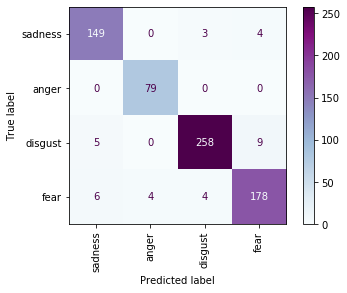

In [27]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=100, min_samples_split=10, n_jobs=-1, verbose=0)

accs = []
reports = []
f1 = []
pr = []
re = []
pe = []

#javed#
accuracy_ = []
P_r_f = []

mean_accuracy= []
mean_p_r_f =[]
##javed###

roc_auc_ = []
roc_auc_one = []
roc_auc_two = []
roc_auc_three = []
roc_auc_four_rf = []

tprs_zero_rf = []
tprs_one_rf = []
tprs_two_rf = []
tprs_three_rf = []
tprs_four_rf = []

mean_fpr_rf = np.linspace(0,1,100)

st_time = time.time()
for train_index, test_index in skfold.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #Oversampling
    #X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
    predictions, accuracy, precision, recall, f1socre, alg_accuracy, alg_p_r_f_score = train_test_model(rf_model, X_train_res, X_test, y_train_res, y_test, labels)
    
    #fpr_zero, tpr_zero, _ = roc_curve(y_test, rf_model.predict_proba(X_test)[:,1], pos_label=0)
    #fpr_one, tpr_one, __ = roc_curve(y_test, rf_model.predict_proba(X_test)[:,1], pos_label=1)
    #fpr_two, tpr_two, ___ = roc_curve(y_test, rf_model.predict_proba(X_test)[:,1], pos_label=2)
    #fpr_three, tpr_three, ____ = roc_curve(y_test, rf_model.predict_proba(X_test)[:,1], pos_label=3)
    fpr_four_rf, tpr_four_rf, _____ = roc_curve(y_test, rf_model.predict_proba (X_test)[:,3], pos_label=3)

    tprs_four_rf.append(interp(mean_fpr_rf, fpr_four_rf, tpr_four_rf))
    
    #roc_auc_one = (auc(fpr_zero, tpr_zero))
    #roc_auc_one = (auc(fpr_one, tpr_one))
    #roc_auc_two = (auc(fpr_two, tpr_two))
    #roc_auc_three = (auc(fpr_three, tpr_three))
    roc_auc_four = (auc(fpr_four_rf, tpr_four_rf))
    
        #javed###      
    accuracy_.append(alg_accuracy)
    P_r_f.append(alg_p_r_f_score)
    #### jave ####

    pe.append(predictions)
    accs.append(accuracy)
    f1.append(f1socre)
    pr.append(precision)
    re.append(recall)


en_time = time.time()
#print('mean predictions: {:.2f} %'.format(sum(pe) / len(pe) ))
print('Total time: {:.2f}s'.format(en_time-st_time))   
print('mean accuracy: {:.2f} %'.format(np.mean(accs)))
print('mean f1 socre: {:.2f} %'.format(np.mean(f1)))
print('mean precision: {:.2f} %'.format(np.mean(pr)))
print('mean recall: {:.2f} %'.format(np.mean(re)))

#roc_zero = sum(roc_auc_) / len(roc_auc_)
#print("\nROC across folds for zero: ", roc_zero)

#roc_one = sum(roc_auc_one) / len(roc_auc_one)
#print("\nROC across folds for one: ", roc_one)

#roc_two = sum(roc_auc_two) / len(roc_auc_two)
#print("\nROC across folds for two: ", roc_two)

#roc_three = sum(roc_auc_three) / len(roc_auc_three)
#print("\nROC across folds for three: ", roc_three)

#roc_four_rf = sum(roc_auc_four_rf) / len(roc_auc_four_rf)
#print("\nROC across folds for four: ", roc_four_rf)

#### jave ####
mean_accuracy= np.mean(accuracy_, axis=0)
print("the average accuracy of RF is",mean_accuracy)
    
mean_p_r_f=np.mean(P_r_f, axis=0)
print("the presion, recall, f are", mean_p_r_f)
#### jave ####


mean_tpr_rf = np.mean(tprs_four_rf, axis=0)
mean_auc_rf = auc(mean_fpr_rf, mean_tpr_rf)

#print(mean_tpr_rf)
#print(mean_fpr_rf)
#print(mean_auc_rf)

#print(metrics_report)
unique, counts = np.unique(y_train_res, return_counts=True)
print(list(zip(unique, counts)))
plot_confusion_matrix(rf_model, X_test, y_test, display_labels=labels, xticks_rotation='vertical', cmap="BuPu")

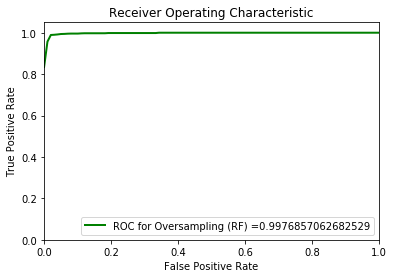

In [28]:
plt.title('Receiver Operating Characteristic')
#plt.plot(fpr_one, tpr_one, 'b', color='red', label= "Oversampling =" +str(roc_one))
#plt.plot(fpr_zero, tpr_zero, 'b', color='green', label= "ROC for 0 label =" +str(roc_zero))
#plt.plot(fpr_one, tpr_one, 'b', label= "ROC for 1 label =" +str(roc_one))
#plt.plot(fpr_two, tpr_two, 'b', color='purple',  label= "ROC for 2 label =" +str(roc_two))
#plt.plot(fpr_three, tpr_three, 'b', color='red',  label= "ROC for 3 label =" +str(roc_three))
plt.plot(mean_fpr_rf, mean_tpr_rf, 'b', color='green', label= "ROC for Oversampling (RF) =" +str(mean_auc_rf),lw=2, alpha=1)
plt.legend(loc = 'lower right')
#plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### KNN

Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Total time: 17.44s
mean accuracy: 0.89 %
mean f1 socre: 0.89 %
mean precision: 0.89 %
mean recall: 0.89 %

ROC across folds for zero:  0.43320806417483315

ROC across folds for one:  0.9949287909492043

ROC across folds for two:  0.41731228903919704

ROC across folds for three:  0.4094987339377454

ROC across folds for four:  nan
the average accuracy of KNN is 0.8904095646842428
the presion, recall, f are [[  0.85971053   0.89628714   0.89381751   0.90939675]
 [  0.86170995   0.90071405   0.9032563    0.89131045]
 [  0.86046906   0.89832602   0

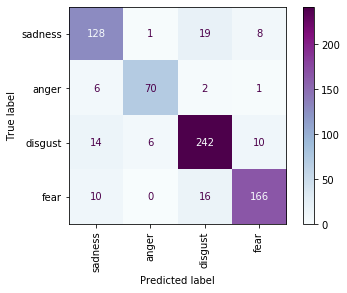

In [29]:
knn_model = KNeighborsClassifier(n_neighbors=3)

accs = []
reports = []
f1 = []
pr = []
re = []
pe = []

#javed#
accuracy_ = []
P_r_f = []

mean_accuracy= []
mean_p_r_f =[]
##javed###

roc_auc_ = []
roc_auc_one = []
roc_auc_two = []
roc_auc_three = []
roc_auc_four = []
st_time = time.time()

mean_fpr_rf = np.linspace(0,1,100)              # change the name of classifier

for train_index, test_index in skfold.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # Oversample
    #X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
    predictions, accuracy, precision, recall, f1socre, alg_accuracy, alg_p_r_f_score = train_test_model(knn_model, X_train, X_test, y_train, y_test, labels)
    
    fpr_zero, tpr_zero, _ = roc_curve(y_test, knn_model.predict_proba(X_test)[:,1], pos_label=0)
    fpr_one, tpr_one, __ = roc_curve(y_test, knn_model.predict_proba(X_test)[:,1], pos_label=1)
    fpr_two, tpr_two, ___ = roc_curve(y_test, knn_model.predict_proba(X_test)[:,1], pos_label=2)
    fpr_three, tpr_three, ____ = roc_curve(y_test, knn_model.predict_proba(X_test)[:,1], pos_label=3)
    fpr_four, tpr_four, _____ = roc_curve(y_test, knn_model.predict_proba (X_test)[:,1], pos_label=4)

    roc_auc_.append(auc(fpr_zero, tpr_zero))
    roc_auc_one.append(auc(fpr_one, tpr_one))
    roc_auc_two.append(auc(fpr_two, tpr_two))
    roc_auc_three.append(auc(fpr_three, tpr_three))
    roc_auc_four.append(auc(fpr_four, tpr_four))
    
            #javed###      
    accuracy_.append(alg_accuracy)
    P_r_f.append(alg_p_r_f_score)
    #### jave ####

    pe.append(predictions)
    accs.append(accuracy)
    f1.append(f1socre)
    pr.append(precision)
    re.append(recall)


en_time = time.time()
#print('mean predictions: {:.2f} %'.format(sum(pe) / len(pe) ))
print('Total time: {:.2f}s'.format(en_time-st_time))   
print('mean accuracy: {:.2f} %'.format(np.mean(accs)))
print('mean f1 socre: {:.2f} %'.format(np.mean(f1)))
print('mean precision: {:.2f} %'.format(np.mean(pr)))
print('mean recall: {:.2f} %'.format(np.mean(re)))

roc_zero = sum(roc_auc_) / len(roc_auc_)
print("\nROC across folds for zero: ", roc_zero)

roc_one = sum(roc_auc_one) / len(roc_auc_one)
print("\nROC across folds for one: ", roc_one)

roc_two = sum(roc_auc_two) / len(roc_auc_two)
print("\nROC across folds for two: ", roc_two)

roc_three = sum(roc_auc_three) / len(roc_auc_three)
print("\nROC across folds for three: ", roc_three)

roc_four = sum(roc_auc_four) / len(roc_auc_four)
print("\nROC across folds for four: ", roc_four)

#### jave ####
mean_accuracy= np.mean(accuracy_, axis=0)
print("the average accuracy of KNN is",mean_accuracy)
    
mean_p_r_f=np.mean(P_r_f, axis=0)
print("the presion, recall, f are", mean_p_r_f)
#### jave ####


mean_tpr_rf = np.mean(tprs_four_rf, axis=0)
mean_auc_rf = auc(mean_fpr_rf, mean_tpr_rf)

#print(fpr_zero)
#print(tpr_zero)

#print(metrics_report)
unique, counts = np.unique(y_train, return_counts=True)
print(list(zip(unique, counts)))
plot_confusion_matrix(knn_model, X_test, y_test, display_labels=labels, xticks_rotation='vertical', cmap="BuPu")

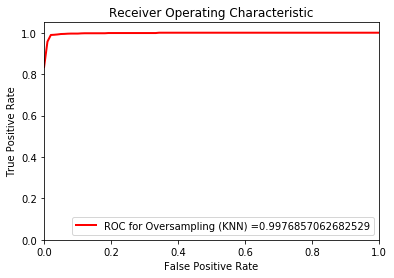

In [30]:
plt.title('Receiver Operating Characteristic')
#plt.plot(fpr_zero, tpr_zero, 'b', color='green', label= "ROC for 0 label =" +str(roc_zero))
#plt.plot(fpr_one, tpr_one, 'b', label= "ROC for 1 label =" +str(roc_one))
#plt.plot(fpr_two, tpr_two, 'b', color='purple',  label= "ROC for 2 label =" +str(roc_two))
#plt.plot(fpr_three, tpr_three, 'b', color='red',  label= "ROC for 3 label =" +str(roc_three))
#plt.plot(fpr_four, tpr_four, 'b', color='yellow', label= "ROC for 4 label =" +str(roc_four))
plt.plot(mean_fpr_rf, mean_tpr_rf, 'b', color='red', label= "ROC for Oversampling (KNN) =" +str(mean_auc_rf),lw=2, alpha=1)
plt.legend(loc = 'lower right')
#plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Multilayer Perceptron

Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Total time: 1645.50s
mean accuracy: 0.98 %
mean f1 socre: 0.98 %
mean precision: 0.98 %
mean recall: 0.98 %
the average accuracy of MLP is 0.9778512160228899
the presion, recall, f are [[  0.96727859   0.96705739   0.98487387   0.98151685]
 [  0.97887473   1.           0.9772786    0.96878778]
 [  0.97298365   0.98318044   0.98103968   0.97502914]
 [156.2         78.5        272.9        192.3       ]]
0.9994089312773238
[(0, 2457), (1, 2457), (2, 2457), (3, 2457)]


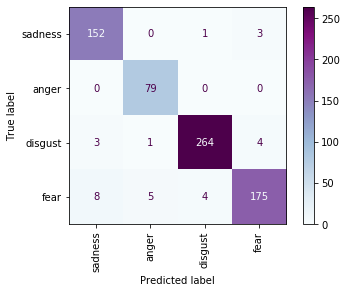

In [31]:
mlp_model = MLPClassifier(random_state=1, max_iter=300)

accs = []
reports = []
f1 = []
pr = []
re = []
pe = []

#javed#
accuracy_ = []
P_r_f = []

mean_accuracy= []
mean_p_r_f =[]
##javed###

roc_auc_ = []
roc_auc_one = []
roc_auc_two = []
roc_auc_three = []
roc_auc_four = []

tprs_zero_mlp = []
tprs_one_mlp = []
tprs_two_mlp = []
tprs_three_mlp = []
tprs_four_mlp = []

mean_fpr_mlp = np.linspace(0,1,100)


st_time = time.time()
for train_index, test_index in skfold.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # Oversample
    #X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
    predictions, accuracy, precision, recall, f1socre, alg_accuracy, alg_p_r_f_score = train_test_model(mlp_model, X_train_res, X_test, y_train_res, y_test, labels)
    
    #fpr_zero, tpr_zero, _ = roc_curve(y_test, mlp_model.predict_proba(X_test)[:,1], pos_label=0)
    #fpr_one, tpr_one, __ = roc_curve(y_test, mlp_model.predict_proba(X_test)[:,1], pos_label=1)
    #fpr_two, tpr_two, ___ = roc_curve(y_test, mlp_model.predict_proba(X_test)[:,1], pos_label=2)
    #fpr_three, tpr_three, ____ = roc_curve(y_test, mlp_model.predict_proba(X_test)[:,1], pos_label=3)
    fpr_four_mlp, tpr_four_mlp, _____ = roc_curve(y_test, mlp_model.predict_proba (X_test)[:,3], pos_label=3)

    tprs_four_mlp.append(interp(mean_fpr_mlp, fpr_four_mlp, tpr_four_mlp))
    
    #roc_auc_one = (auc(fpr_zero, tpr_zero))
    #roc_auc_one = (auc(fpr_one, tpr_one))
    #roc_auc_two = (auc(fpr_two, tpr_two))
    #roc_auc_three = (auc(fpr_three, tpr_three))
    roc_auc_four = (auc(fpr_four_mlp, tpr_four_mlp))
    
        
            #javed###      
    accuracy_.append(alg_accuracy)
    P_r_f.append(alg_p_r_f_score)
    #### jave ####

    pe.append(predictions)
    accs.append(accuracy)
    f1.append(f1socre)
    pr.append(precision)
    re.append(recall)


en_time = time.time()
#print('mean predictions: {:.2f} %'.format(sum(pe) / len(pe) ))
print('Total time: {:.2f}s'.format(en_time-st_time))   
print('mean accuracy: {:.2f} %'.format(np.mean(accs)))
print('mean f1 socre: {:.2f} %'.format(np.mean(f1)))
print('mean precision: {:.2f} %'.format(np.mean(pr)))
print('mean recall: {:.2f} %'.format(np.mean(re)))

#roc_zero = sum(roc_auc_) / len(roc_auc_)
#print("\nROC across folds for zero: ", roc_zero)

#roc_one = sum(roc_auc_one) / len(roc_auc_one)
#print("\nROC across folds for one: ", roc_one)

#roc_two = sum(roc_auc_two) / len(roc_auc_two)
#print("\nROC across folds for two: ", roc_two)

#roc_three = sum(roc_auc_three) / len(roc_auc_three)
#print("\nROC across folds for three: ", roc_three)

#roc_four = sum(roc_auc_four) / len(roc_auc_four)
#print("\nROC across folds for four: ", roc_four)
mean_tpr_mlp = np.mean(tprs_four_mlp, axis=0)
mean_auc_mlp = auc(mean_fpr_mlp, mean_tpr_mlp)

#### jave ####
mean_accuracy= np.mean(accuracy_, axis=0)
print("the average accuracy of MLP is",mean_accuracy)
    
mean_p_r_f=np.mean(P_r_f, axis=0)
print("the presion, recall, f are", mean_p_r_f)
#### jave ####

#print(mean_tpr_mlp)
#print(mean_fpr_mlp)
print(mean_auc_mlp)

#print(metrics_report)
unique, counts = np.unique(y_train_res, return_counts=True)
print(list(zip(unique, counts)))
plot_confusion_matrix(mlp_model, X_test, y_test, display_labels=labels, xticks_rotation='vertical', cmap="BuPu")

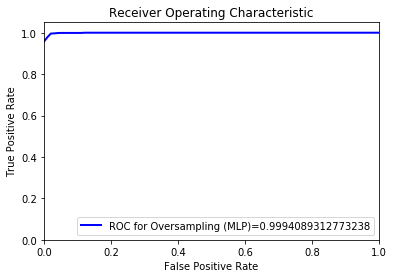

In [32]:
plt.title('Receiver Operating Characteristic')
#plt.plot(fpr_one, tpr_one, 'b', color='green', label= "Oversampling =" +str(roc_one))
#plt.plot(fpr_zero, tpr_zero, 'b', color='green', label= "ROC for 0 label =" +str(roc_zero))
#plt.plot(fpr_one, tpr_one, 'b', label= "ROC for 1 label =" +str(roc_one))
#plt.plot(fpr_two, tpr_two, 'b', color='purple',  label= "ROC for 2 label =" +str(roc_two))
#plt.plot(fpr_three, tpr_three, 'b', color='red',  label= "ROC for 3 label =" +str(roc_three))
plt.plot(mean_fpr_mlp, mean_tpr_mlp, 'b', label= "ROC for Oversampling (MLP)=" +str(mean_auc_mlp),lw=2, alpha=1)
plt.legend(loc = 'lower right')
#plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Gradient Boosting Classifier

Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Total time: 38.20s
mean accuracy: 0.75 %
mean f1 socre: 0.75 %
mean precision: 0.75 %
mean recall: 0.75 %

ROC across folds for zero:  0.3584279975601348

ROC across folds for one:  0.9359587523933369

ROC across folds for two:  0.48965556272950544

ROC across folds for three:  0.41770662369813677

ROC across folds for four:  nan
the average accuracy of GB is 0.7466826078070714
the presion, recall, f are [[  0.82236782   0.7413619    0.70682026   0.7733698 ]
 [  0.65429936   0.75287244   0.84024591   0.68639627]
 [  0.72772413   0.74637697   0.

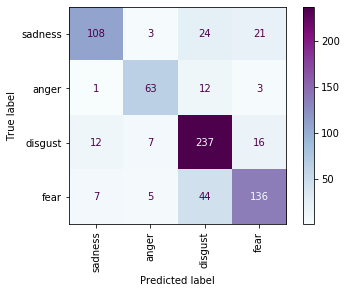

In [33]:
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)

accs = []
reports = []
f1 = []
pr = []
re = []
pe = []

#javed#
accuracy_ = []
P_r_f = []

mean_accuracy= []
mean_p_r_f =[]
##javed###

roc_auc_ = []
roc_auc_one = []
roc_auc_two = []
roc_auc_three = []
roc_auc_four = []
st_time = time.time()
for train_index, test_index in skfold.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # Oversample
    #X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
    predictions, accuracy, precision, recall, f1socre, alg_accuracy, alg_p_r_f_score = train_test_model(gb_model, X_train, X_test, y_train, y_test, labels)
    
    fpr_zero, tpr_zero, _ = roc_curve(y_test, gb_model.predict_proba(X_test)[:,1], pos_label=0)
    fpr_one, tpr_one, __ = roc_curve(y_test, gb_model.predict_proba(X_test)[:,1], pos_label=1)
    fpr_two, tpr_two, ___ = roc_curve(y_test, gb_model.predict_proba(X_test)[:,1], pos_label=2)
    fpr_three, tpr_three, ____ = roc_curve(y_test, gb_model.predict_proba(X_test)[:,1], pos_label=3)
    fpr_four, tpr_four, _____ = roc_curve(y_test, gb_model.predict_proba (X_test)[:,1], pos_label=4)

    roc_auc_.append(auc(fpr_zero, tpr_zero))
    roc_auc_one.append(auc(fpr_one, tpr_one))
    roc_auc_two.append(auc(fpr_two, tpr_two))
    roc_auc_three.append(auc(fpr_three, tpr_three))
    roc_auc_four.append(auc(fpr_four, tpr_four))
    
                #javed###      
    accuracy_.append(alg_accuracy)
    P_r_f.append(alg_p_r_f_score)
    #### jave ####

    pe.append(predictions)
    accs.append(accuracy)
    f1.append(f1socre)
    pr.append(precision)
    re.append(recall)


en_time = time.time()
#print('mean predictions: {:.2f} %'.format(sum(pe) / len(pe) ))
print('Total time: {:.2f}s'.format(en_time-st_time))   
print('mean accuracy: {:.2f} %'.format(np.mean(accs)))
print('mean f1 socre: {:.2f} %'.format(np.mean(f1)))
print('mean precision: {:.2f} %'.format(np.mean(pr)))
print('mean recall: {:.2f} %'.format(np.mean(re)))

roc_zero = sum(roc_auc_) / len(roc_auc_)
print("\nROC across folds for zero: ", roc_zero)

roc_one = sum(roc_auc_one) / len(roc_auc_one)
print("\nROC across folds for one: ", roc_one)

roc_two = sum(roc_auc_two) / len(roc_auc_two)
print("\nROC across folds for two: ", roc_two)

roc_three = sum(roc_auc_three) / len(roc_auc_three)
print("\nROC across folds for three: ", roc_three)

roc_four = sum(roc_auc_four) / len(roc_auc_four)
print("\nROC across folds for four: ", roc_four)

#### jave ####
mean_accuracy= np.mean(accuracy_, axis=0)
print("the average accuracy of GB is",mean_accuracy)
    
mean_p_r_f=np.mean(P_r_f, axis=0)
print("the presion, recall, f are", mean_p_r_f)
#### jave ####

#print(fpr_zero)
#print(tpr_zero)

#print(metrics_report)
unique, counts = np.unique(y_train, return_counts=True)
print(list(zip(unique, counts)))
plot_confusion_matrix(gb_model, X_test, y_test, display_labels=labels, xticks_rotation='vertical', cmap="BuPu")

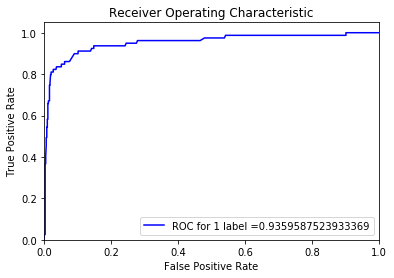

In [34]:
plt.title('Receiver Operating Characteristic')
#plt.plot(fpr_zero, tpr_zero, 'b', color='green', label= "ROC for 0 label =" +str(roc_zero))
plt.plot(fpr_one, tpr_one, 'b', label= "ROC for 1 label =" +str(roc_one))
#plt.plot(fpr_two, tpr_two, 'b', color='purple',  label= "ROC for 2 label =" +str(roc_two))
#plt.plot(fpr_three, tpr_three, 'b', color='red',  label= "ROC for 3 label =" +str(roc_three))
#plt.plot(fpr_four, tpr_four, 'b', color='yellow', label= "ROC for 4 label =" +str(roc_four))
plt.legend(loc = 'lower right')
#plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Ensemble Methods
Ensemble methods are techniques that create multiple models and then combine them to produce improved results. 

### Voting Classifier

Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Total time: 2108.89s
mean accuracy: 0.97 %
mean f1 socre: 0.97 %
mean precision: 0.97 %
mean recall: 0.97 %
the average accuracy of Voting is 0.9675659104843655
the presion, recall, f are [[  0.94873432   0.97785041   0.96928845   0.9777728 ]
 [  0.95711253   0.99363843   0.97325334   0.95734564]
 [  0.95256747   0.98555632   0.97111097   0.96735804]
 [156.2         78.5        272.9        192.3       ]]
[(0, 1406), (1, 706), (2, 2457), (3, 1731)]


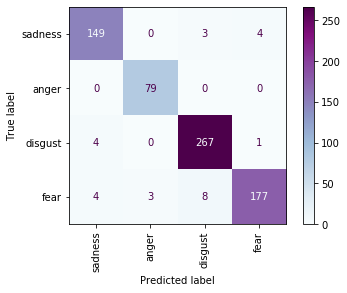

In [35]:
mlp_model = MLPClassifier(random_state=1, max_iter=300)

vote_model = VotingClassifier(estimators=[('mlp', mlp_model),('mlp1', mlp_model)], voting='soft')

accs = []
reports = []
f1 = []
pr = []
re =[]

#javed#
accuracy_ = []
P_r_f = []

mean_accuracy= []
mean_p_r_f =[]
##javed###

#
roc_auc_ = []
roc_auc_one = []
roc_auc_two = []
roc_auc_three = []
roc_auc_four = []

tprs_zero_v = []
tprs_one_v = []
tprs_two_v = []
tprs_three_v = []
tprs_four_v = []

mean_fpr_v = np.linspace(0,1,100)
#
st_time = time.time()
for train_index, test_index in skfold.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # Oversample
    # X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
    predictions, accuracy, f1socre, precision, recall, alg_accuracy, alg_p_r_f_score = train_test_model(vote_model, X_train, X_test, y_train, y_test, labels)
    accs.append(accuracy)
    f1.append(f1socre)
    pr.append(precision)
    re.append(recall)
    #reports.append(metrics_report)
    fpr_four_v, tpr_four_v, _____ = roc_curve(y_test, vote_model.predict_proba (X_test)[:,3], pos_label=3)     #
    tprs_four_v.append(interp(mean_fpr_v, fpr_four_v, tpr_four_v))                                             #
    roc_auc_four = (auc(fpr_four_v, tpr_four_v))                                                               #
    

    
                #javed###      
    accuracy_.append(alg_accuracy)
    P_r_f.append(alg_p_r_f_score)
    #### jave ####

en_time = time.time()
print('Total time: {:.2f}s'.format(en_time-st_time)) 
print('mean accuracy: {:.2f} %'.format(np.mean(accs)))
print('mean f1 socre: {:.2f} %'.format(np.mean(f1)))
print('mean precision: {:.2f} %'.format(np.mean(pr)))
print('mean recall: {:.2f} %'.format(np.mean(re)))

#
mean_tpr_v = np.mean(tprs_four_v, axis=0)
mean_auc_v = auc(mean_fpr_v, mean_tpr_v)
#
#### jave ####
mean_accuracy= np.mean(accuracy_, axis=0)
print("the average accuracy of Voting is",mean_accuracy)
    
mean_p_r_f=np.mean(P_r_f, axis=0)
print("the presion, recall, f are", mean_p_r_f)
#### jave ####

unique, counts = np.unique(y_train, return_counts=True)
print(list(zip(unique, counts)))
plot_confusion_matrix(vote_model, X_test, y_test, display_labels=labels, xticks_rotation='vertical', cmap="BuPu")

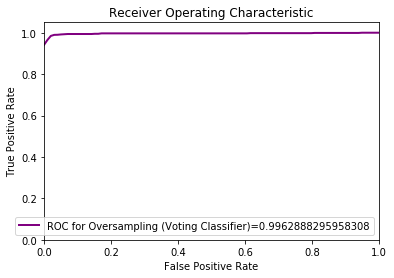

In [36]:
plt.title('Receiver Operating Characteristic')
plt.plot(mean_fpr_v, mean_tpr_v, 'b', color='purple', label= "ROC for Oversampling (Voting Classifier)=" +str(mean_auc_v),lw=2, alpha=1)
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### AdaBoost
The core principle of AdaBoost is to fit a sequence of weak learners (i.e., models that are only slightly better than random guessing, such as small decision trees) on repeatedly modified versions of the data.

Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Total time: 70.86s
mean accuracy: 0.57 %
mean f1 socre: 0.58 %
mean precision: 0.57 %
mean recall: 0.57 %
the average accuracy of AdaBoost is 0.5690844062947068
the presion, recall, f are [[  0.50967702   0.72024437   0.5906243    0.55080715]
 [  0.61718929   0.71212269   0.46208118   0.62345099]
 [  0.55753687   0.71486453   0.51750567   0.58410064]
 [156.2         78.5        272.9        192.3       ]]
[(0, 1406), (1, 706), (2, 2457), (3, 1731)]


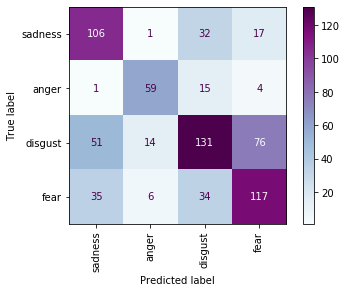

In [37]:
ada_model = AdaBoostClassifier(n_estimators=500)

accs = []
reports = []
f1 = []
pr = []
re =[]

#javed#
accuracy_ = []
P_r_f = []

mean_accuracy= []
mean_p_r_f =[]
##javed###

st_time = time.time()
for train_index, test_index in skfold.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # Oversample
    # X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
    predictions, accuracy, f1socre, precision, recall, alg_accuracy, alg_p_r_f_score = train_test_model(ada_model, X_train, X_test, y_train, y_test, labels)
    accs.append(accuracy)
    f1.append(f1socre)
    pr.append(precision)
    re.append(recall)
    #reports.append(metrics_report)
    
        
                #javed###      
    accuracy_.append(alg_accuracy)
    P_r_f.append(alg_p_r_f_score)
    #### jave ####

en_time = time.time()
print('Total time: {:.2f}s'.format(en_time-st_time)) 
print('mean accuracy: {:.2f} %'.format(np.mean(accs)))
print('mean f1 socre: {:.2f} %'.format(np.mean(f1)))
print('mean precision: {:.2f} %'.format(np.mean(pr)))
print('mean recall: {:.2f} %'.format(np.mean(re)))

#### jave ####
mean_accuracy= np.mean(accuracy_, axis=0)
print("the average accuracy of AdaBoost is",mean_accuracy)
    
mean_p_r_f=np.mean(P_r_f, axis=0)
print("the presion, recall, f are", mean_p_r_f)
#### jave ####

unique, counts = np.unique(y_train, return_counts=True)
print(list(zip(unique, counts)))
plot_confusion_matrix(ada_model, X_test, y_test, display_labels=labels, xticks_rotation='vertical', cmap="BuPu")

# Undersampling

### MultinomialNB

Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Total time: 0.56s
mean accuracy: 0.67 %
mean f1 socre: 0.69 %
mean precision: 0.67 %
mean recall: 0.67 %

ROC across folds for zero:  0.3596755478690771

ROC across folds for one:  0.9609824673853338

ROC across folds for two:  0.46027359398992884

ROC across folds for three:  0.4391513759306678

ROC across folds for four:  nan
the average accuracy of NBM is 0.6676680972818312
the presion, recall, f are [[  0.64382552   0.54053004   0.79602852   0.65506539]
 [  0.68373346   0.90579357   0.55001616   0.72436043]
 [  0.66287059   0.6763036    0.6

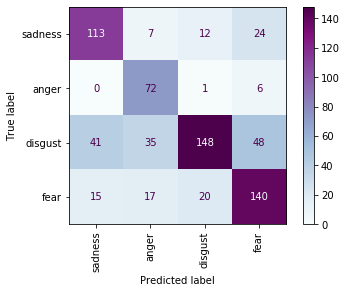

In [38]:
nb_model = MultinomialNB()

accs = []
reports = []
f1 = []
pr = []
re = []
pe = []

#javed#
accuracy_ = []
P_r_f = []

mean_accuracy= []
mean_p_r_f =[]
##javed###

roc_auc_ = []
roc_auc_one = []
roc_auc_two = []
roc_auc_three = []
roc_auc_four = []
st_time = time.time()
for train_index, test_index in skfold.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # Undersampling
    X_train_under, y_train_under = rus.fit_resample(X_train, y_train)
    predictions, accuracy, f1socre, precision, recall, alg_accuracy, alg_p_r_f_score = train_test_model(nb_model, X_train_under, X_test, y_train_under, y_test, labels)

    fpr_zero, tpr_zero, _ = roc_curve(y_test, nb_model.predict_proba(X_test)[:,1], pos_label=0)
    fpr_one, tpr_one, __ = roc_curve(y_test, nb_model.predict_proba(X_test)[:,1], pos_label=1)
    fpr_two, tpr_two, ___ = roc_curve(y_test, nb_model.predict_proba(X_test)[:,1], pos_label=2)
    fpr_three, tpr_three, ____ = roc_curve(y_test, nb_model.predict_proba(X_test)[:,1], pos_label=3)
    fpr_four, tpr_four, _____ = roc_curve(y_test, nb_model.predict_proba (X_test)[:,1], pos_label=4)

    roc_auc_.append(auc(fpr_zero, tpr_zero))
    roc_auc_one.append(auc(fpr_one, tpr_one))
    roc_auc_two.append(auc(fpr_two, tpr_two))
    roc_auc_three.append(auc(fpr_three, tpr_three))
    roc_auc_four.append(auc(fpr_four, tpr_four))
    
                 #javed###      
    accuracy_.append(alg_accuracy)
    P_r_f.append(alg_p_r_f_score)
    #### jave ####

    pe.append(predictions)
    accs.append(accuracy)
    f1.append(f1socre)
    pr.append(precision)
    re.append(recall)


en_time = time.time()
#print('mean predictions: {:.2f} %'.format(sum(pe) / len(pe) ))
print('Total time: {:.2f}s'.format(en_time-st_time))   
print('mean accuracy: {:.2f} %'.format(np.mean(accs)))
print('mean f1 socre: {:.2f} %'.format(np.mean(f1)))
print('mean precision: {:.2f} %'.format(np.mean(pr)))
print('mean recall: {:.2f} %'.format(np.mean(re)))

roc_zero = sum(roc_auc_) / len(roc_auc_)
print("\nROC across folds for zero: ", roc_zero)

roc_one = sum(roc_auc_one) / len(roc_auc_one)
print("\nROC across folds for one: ", roc_one)

roc_two = sum(roc_auc_two) / len(roc_auc_two)
print("\nROC across folds for two: ", roc_two)

roc_three = sum(roc_auc_three) / len(roc_auc_three)
print("\nROC across folds for three: ", roc_three)

roc_four = sum(roc_auc_four) / len(roc_auc_four)
print("\nROC across folds for four: ", roc_four)

#### jave ####
mean_accuracy= np.mean(accuracy_, axis=0)
print("the average accuracy of NBM is",mean_accuracy)
    
mean_p_r_f=np.mean(P_r_f, axis=0)
print("the presion, recall, f are", mean_p_r_f)
#### jave ####

#print(fpr_zero)
#print(tpr_zero)

#print(metrics_report)
unique, counts = np.unique(y_train_res, return_counts=True)
print(list(zip(unique, counts)))
plot_confusion_matrix(nb_model, X_test, y_test, display_labels=labels, xticks_rotation='vertical', cmap="BuPu")

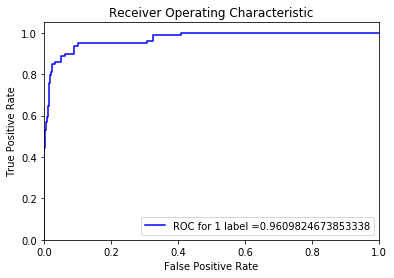

In [39]:
plt.title('Receiver Operating Characteristic')
#plt.plot(fpr_zero, tpr_zero, 'b', color='green', label= "ROC for 0 label =" +str(roc_zero))
plt.plot(fpr_one, tpr_one, 'b', label= "ROC for 1 label =" +str(roc_one))
#plt.plot(fpr_two, tpr_two, 'b', color='purple',  label= "ROC for 2 label =" +str(roc_two))
#plt.plot(fpr_three, tpr_three, 'b', color='red',  label= "ROC for 3 label =" +str(roc_three))
#plt.plot(fpr_four, tpr_four, 'b', color='yellow', label= "ROC for 4 label =" +str(roc_four))
plt.legend(loc = 'lower right')
#plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### LogisticRegression

Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Total time: 7.17s
mean accuracy: 0.78 %
mean f1 socre: 0.78 %
mean precision: 0.78 %
mean recall: 0.77 %

ROC across folds for zero:  0.37225434044931127

ROC across folds for one:  0.990055902328363

ROC across folds for two:  0.4534726390556223

ROC across folds for three:  0.4218053614848364

ROC across folds for four:  nan
the average accuracy of LR is 0.7751085223789087
the presion, recall, f are [[  0.74112901   0.74241267   0.82960476   0.7584521 ]
 [  0.78423567   0.98474521   0.70977968   0.77478411]
 [  0.76155638   0.84598109   0.764

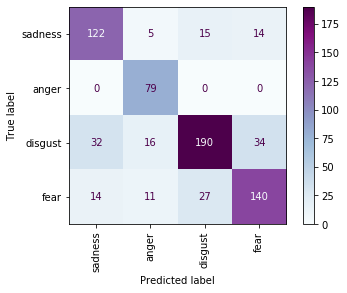

In [40]:
log_model = LogisticRegression(penalty='l2', max_iter=500)

accs = []
reports = []
f1 = []
pr = []
re = []
pe = []

#javed#
accuracy_ = []
P_r_f = []

mean_accuracy= []
mean_p_r_f =[]
##javed###

roc_auc_ = []
roc_auc_one = []
roc_auc_two = []
roc_auc_three = []
roc_auc_four = []
st_time = time.time()
for train_index, test_index in skfold.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # Undersampling
    X_train_under, y_train_under = rus.fit_resample(X_train, y_train)
    predictions, accuracy, f1socre, precision, recall, alg_accuracy, alg_p_r_f_score = train_test_model(log_model, X_train_under, X_test, y_train_under, y_test, labels)

    fpr_zero, tpr_zero, _ = roc_curve(y_test, log_model.predict_proba(X_test)[:,1], pos_label=0)
    fpr_one, tpr_one, __ = roc_curve(y_test, log_model.predict_proba(X_test)[:,1], pos_label=1)
    fpr_two, tpr_two, ___ = roc_curve(y_test, log_model.predict_proba(X_test)[:,1], pos_label=2)
    fpr_three, tpr_three, ____ = roc_curve(y_test, log_model.predict_proba(X_test)[:,1], pos_label=3)
    fpr_four, tpr_four, _____ = roc_curve(y_test, log_model.predict_proba (X_test)[:,1], pos_label=4)

    roc_auc_.append(auc(fpr_zero, tpr_zero))
    roc_auc_one.append(auc(fpr_one, tpr_one))
    roc_auc_two.append(auc(fpr_two, tpr_two))
    roc_auc_three.append(auc(fpr_three, tpr_three))
    roc_auc_four.append(auc(fpr_four, tpr_four))
    
                     #javed###      
    accuracy_.append(alg_accuracy)
    P_r_f.append(alg_p_r_f_score)
    #### jave ####


    pe.append(predictions)
    accs.append(accuracy)
    f1.append(f1socre)
    pr.append(precision)
    re.append(recall)


en_time = time.time()
#print('mean predictions: {:.2f} %'.format(sum(pe) / len(pe) ))
print('Total time: {:.2f}s'.format(en_time-st_time))   
print('mean accuracy: {:.2f} %'.format(np.mean(accs)))
print('mean f1 socre: {:.2f} %'.format(np.mean(f1)))
print('mean precision: {:.2f} %'.format(np.mean(pr)))
print('mean recall: {:.2f} %'.format(np.mean(re)))

roc_zero = sum(roc_auc_) / len(roc_auc_)
print("\nROC across folds for zero: ", roc_zero)

roc_one = sum(roc_auc_one) / len(roc_auc_one)
print("\nROC across folds for one: ", roc_one)

roc_two = sum(roc_auc_two) / len(roc_auc_two)
print("\nROC across folds for two: ", roc_two)

roc_three = sum(roc_auc_three) / len(roc_auc_three)
print("\nROC across folds for three: ", roc_three)

roc_four = sum(roc_auc_four) / len(roc_auc_four)
print("\nROC across folds for four: ", roc_four)

#### jave ####
mean_accuracy= np.mean(accuracy_, axis=0)
print("the average accuracy of LR is",mean_accuracy)
    
mean_p_r_f=np.mean(P_r_f, axis=0)
print("the presion, recall, f are", mean_p_r_f)
#### jave ####

#print(fpr_zero)
#print(tpr_zero)

#print(metrics_report)
unique, counts = np.unique(y_train_res, return_counts=True)
print(list(zip(unique, counts)))
plot_confusion_matrix(log_model, X_test, y_test, display_labels=labels, xticks_rotation='vertical', cmap="BuPu")

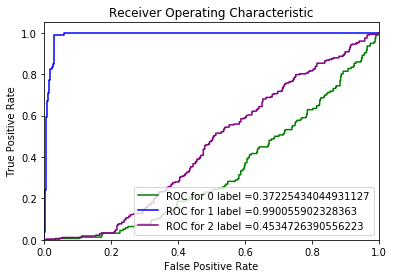

In [41]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_zero, tpr_zero, 'b', color='green', label= "ROC for 0 label =" +str(roc_zero))
plt.plot(fpr_one, tpr_one, 'b', label= "ROC for 1 label =" +str(roc_one))
plt.plot(fpr_two, tpr_two, 'b', color='purple',  label= "ROC for 2 label =" +str(roc_two))
#plt.plot(fpr_three, tpr_three, 'b', color='red',  label= "ROC for 3 label =" +str(roc_three))
#plt.plot(fpr_four, tpr_four, 'b', color='yellow', label= "ROC for 4 label =" +str(roc_four))
plt.legend(loc = 'lower right')
#plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### LinearSVC

Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Total time: 2.84s
mean accuracy: 0.76 %
mean f1 socre: 0.77 %
mean precision: 0.76 %
mean recall: 0.76 %
the average accuracy of SVC is 0.7609636215001021
the presion, recall, f are [[  0.73780967   0.70852512   0.82026969   0.742475  ]
 [  0.77207251   0.97455372   0.69145389   0.76334467]
 [  0.75379025   0.81990737   0.74991376   0.75244568]
 [156.2         78.5        272.9        192.3       ]]
0.9054320559774222
[(0, 2457), (1, 2457), (2, 2457), (3, 2457)]


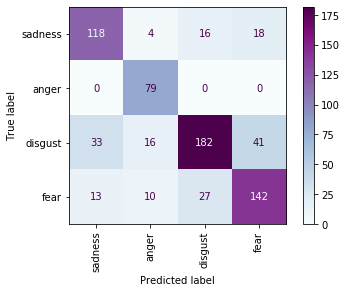

In [42]:
svm = LinearSVC(class_weight='balanced', verbose=False, max_iter=10000, tol=1e-4, C=0.1)

accs = []
reports = []
f1 = []
pr = []
re = []
pe = []

#javed#
accuracy_ = []
P_r_f = []

mean_accuracy= []
mean_p_r_f =[]
##javed###

roc_auc_ = []
roc_auc_one = []
roc_auc_two = []
roc_auc_three = []
roc_auc_four_svm = []

tprs_zero_svm_under = []
tprs_one_svm_under = []
tprs_two_svm_under = []
tprs_three_svm_under = []
tprs_four_svm_under = []

mean_fpr_svm_under = np.linspace(0,1,100)

st_time = time.time()
for train_index, test_index in skfold.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # Undersampling
    X_train_under, y_train_under = rus.fit_resample(X_train, y_train)
    predictions, accuracy, f1socre, precision, recall, alg_accuracy, alg_p_r_f_score = train_test_model(svm, X_train_under, X_test, y_train_under, y_test, labels)

    #fpr_zero, tpr_zero, _ = roc_curve(y_test, svm.decision_function(X_test)[:,1], pos_label=0)
    #fpr_one, tpr_one, __ = roc_curve(y_test, svm.decision_function(X_test)[:,1], pos_label=1)
    #fpr_two, tpr_two, ___ = roc_curve(y_test, svm.decision_function(X_test)[:,1], pos_label=2)
    #fpr_three, tpr_three, ____ = roc_curve(y_test, svm.decision_function(X_test)[:,1], pos_label=3)
    fpr_four_under_svm, tpr_four_under_svm, _____ = roc_curve(y_test, svm.decision_function (X_test)[:,3], pos_label=3)

    tprs_four_svm_under.append(interp(mean_fpr_svm_under, fpr_four_under_svm, tpr_four_under_svm))
    
    #roc_auc_one = (auc(fpr_zero, tpr_zero))
    #roc_auc_one = (auc(fpr_one, tpr_one))
    #roc_auc_two = (auc(fpr_two, tpr_two))
    #roc_auc_three = (auc(fpr_three, tpr_three))
    roc_auc_four = (auc(fpr_four_under_svm, tpr_four_under_svm))
    
                         #javed###      
    accuracy_.append(alg_accuracy)
    P_r_f.append(alg_p_r_f_score)
    #### jave ####


    pe.append(predictions)
    accs.append(accuracy)
    f1.append(f1socre)
    pr.append(precision)
    re.append(recall)


en_time = time.time()
#print('mean predictions: {:.2f} %'.format(sum(pe) / len(pe) ))
print('Total time: {:.2f}s'.format(en_time-st_time))   
print('mean accuracy: {:.2f} %'.format(np.mean(accs)))
print('mean f1 socre: {:.2f} %'.format(np.mean(f1)))
print('mean precision: {:.2f} %'.format(np.mean(pr)))
print('mean recall: {:.2f} %'.format(np.mean(re)))

#roc_zero = sum(roc_auc_) / len(roc_auc_)
#print("\nROC across folds for zero: ", roc_zero)

#roc_one = sum(roc_auc_one) / len(roc_auc_one)
#print("\nROC across folds for one: ", roc_one)

#roc_two = sum(roc_auc_two) / len(roc_auc_two)
#print("\nROC across folds for two: ", roc_two)

#roc_three = sum(roc_auc_three) / len(roc_auc_three)
#print("\nROC across folds for three: ", roc_three)

#roc_four_under_svm = sum(roc_auc_four_svm) / len(roc_auc_four_svm)
#print("\nROC across folds for four: ", roc_four_under_svm)

mean_tpr_svm_under = np.mean(tprs_four_svm_under, axis=0)
mean_auc_svm_under = auc(mean_fpr_svm_under, mean_tpr_svm_under)

#### jave ####
mean_accuracy= np.mean(accuracy_, axis=0)
print("the average accuracy of SVC is",mean_accuracy)
    
mean_p_r_f=np.mean(P_r_f, axis=0)
print("the presion, recall, f are", mean_p_r_f)
#### jave ####

#print(mean_tpr_svm_under)
#print(mean_fpr_svm_under)
print(mean_auc_svm_under)

#print(metrics_report)
unique, counts = np.unique(y_train_res, return_counts=True)
print(list(zip(unique, counts)))
plot_confusion_matrix(svm, X_test, y_test, display_labels=labels, xticks_rotation='vertical', cmap="BuPu")

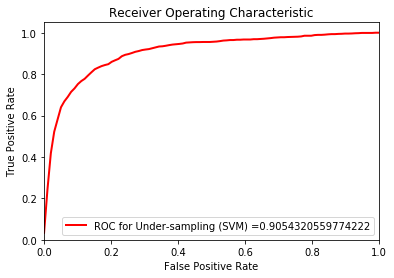

In [43]:
plt.title('Receiver Operating Characteristic')
#plt.plot(fpr_zero, tpr_zero, 'b', color='green', label= "ROC for 0 label =" +str(roc_zero))
#plt.plot(fpr_one, tpr_one, 'b', label= "ROC for 1 label =" +str(roc_one))
#plt.plot(fpr_two, tpr_two, 'b', color='purple',  label= "ROC for 2 label =" +str(roc_two))
#plt.plot(fpr_three, tpr_three, 'b', color='red',  label= "ROC for 3 label =" +str(roc_three))
plt.plot(mean_fpr_svm_under, mean_tpr_svm_under, 'b', color='red', label= "ROC for Under-sampling (SVM) =" +str(mean_auc_svm_under) ,lw=2, alpha=1)
plt.legend(loc = 'lower right')
#plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### RandomForestClassifier

Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Total time: 16.75s
mean accuracy: 0.79 %
mean f1 socre: 0.80 %
mean precision: 0.79 %
mean recall: 0.79 %
the average accuracy of RF is 0.7945411812793788
the presion, recall, f are [[  0.80385549   0.72572679   0.81641518   0.79967315]
 [  0.77143965   0.98472898   0.76108732   0.78312014]
 [  0.78683626   0.8351928    0.78740949   0.79046858]
 [156.2         78.5        272.9        192.3       ]]
0.932491087565921
[(0, 2457), (1, 2457), (2, 2457), (3, 2457)]


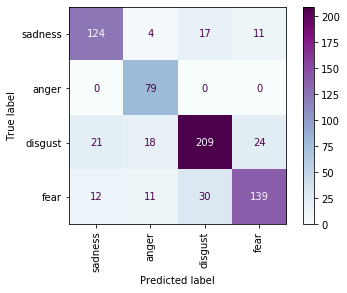

In [44]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=100, min_samples_split=10, n_jobs=-1, verbose=0)

accs = []
reports = []
f1 = []
pr = []
re = []
pe = []

#javed#
accuracy_ = []
P_r_f = []

mean_accuracy= []
mean_p_r_f =[]
##javed###

roc_auc_ = []
roc_auc_under = []
roc_auc_two = []
roc_auc_three = []
roc_auc_four_under = []

tprs_zero_rf_under = []
tprs_one_rf_under = []
tprs_two_rf_under = []
tprs_three_rf_under = []
tprs_four_rf_under = []

mean_fpr_rf_under = np.linspace(0,1,100)

st_time = time.time()
for train_index, test_index in skfold.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # Undersampling
    X_train_under, y_train_under = rus.fit_resample(X_train, y_train)
    predictions, accuracy, f1socre, precision, recall, alg_accuracy, alg_p_r_f_score = train_test_model(rf_model, X_train_under, X_test, y_train_under, y_test, labels)

    #fpr_zero, tpr_zero, _ = roc_curve(y_test, rf_model.predict_proba(X_test)[:,1], pos_label=0)
    #fpr_under, tpr_under, __ = roc_curve(y_test, rf_model.predict_proba(X_test)[:,1], pos_label=1)
    #fpr_two, tpr_two, ___ = roc_curve(y_test, rf_model.predict_proba(X_test)[:,1], pos_label=2)
    #fpr_three, tpr_three, ____ = roc_curve(y_test, rf_model.predict_proba(X_test)[:,1], pos_label=3)
    fpr_four_under_rf, tpr_four_under_rf, _____ = roc_curve(y_test, rf_model.predict_proba (X_test)[:,3], pos_label=3)

    tprs_four_rf_under.append(interp(mean_fpr_rf_under, fpr_four_under_rf, tpr_four_under_rf))
    
    #roc_auc_one = (auc(fpr_zero, tpr_zero))
    #roc_auc_one = (auc(fpr_one, tpr_one))
    #roc_auc_two = (auc(fpr_two, tpr_two))
    #roc_auc_three = (auc(fpr_three, tpr_three))
    roc_auc_four = (auc(fpr_four_rf, tpr_four_rf))
    
                             #javed###      
    accuracy_.append(alg_accuracy)
    P_r_f.append(alg_p_r_f_score)
    #### jave ####

    pe.append(predictions)
    accs.append(accuracy)
    f1.append(f1socre)
    pr.append(precision)
    re.append(recall)


en_time = time.time()
#print('mean predictions: {:.2f} %'.format(sum(pe) / len(pe) ))
print('Total time: {:.2f}s'.format(en_time-st_time))   
print('mean accuracy: {:.2f} %'.format(np.mean(accs)))
print('mean f1 socre: {:.2f} %'.format(np.mean(f1)))
print('mean precision: {:.2f} %'.format(np.mean(pr)))
print('mean recall: {:.2f} %'.format(np.mean(re)))

#roc_zero = sum(roc_auc_) / len(roc_auc_)
#print("\nROC across folds for zero: ", roc_zero)

#roc_one_under = sum(roc_auc_under) / len(roc_auc_under)
#print("\nROC across folds for one: ", roc_one_under)

#roc_two = sum(roc_auc_two) / len(roc_auc_two)
#print("\nROC across folds for two: ", roc_two)

#roc_three = sum(roc_auc_three) / len(roc_auc_three)
#print("\nROC across folds for three: ", roc_three)

#roc_four_under_rf = sum(roc_auc_four_under) / len(roc_auc_four_under)
#print("\nROC across folds for four: ", roc_four_under_rf)

mean_tpr_rf_under = np.mean(tprs_four_rf_under, axis=0)
mean_auc_rf_under = auc(mean_fpr_rf_under, mean_tpr_rf_under)

#### jave ####
mean_accuracy= np.mean(accuracy_, axis=0)
print("the average accuracy of RF is",mean_accuracy)
    
mean_p_r_f=np.mean(P_r_f, axis=0)
print("the presion, recall, f are", mean_p_r_f)
#### jave ####

#print(mean_tpr_rf_under)
#print(mean_fpr_rf_under)
print(mean_auc_rf_under)

#print(metrics_report)
unique, counts = np.unique(y_train_res, return_counts=True)
print(list(zip(unique, counts)))
plot_confusion_matrix(rf_model, X_test, y_test, display_labels=labels, xticks_rotation='vertical', cmap="BuPu")

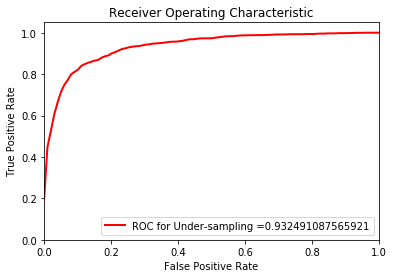

In [45]:
plt.title('Receiver Operating Characteristic')
#plt.plot(fpr_under, tpr_under, 'b', label= "Under-sampling =" +str(roc_one_under))
#plt.plot(fpr_zero, tpr_zero, 'b', color='green', label= "ROC for 0 label =" +str(roc_zero))
#plt.plot(fpr_one, tpr_one, 'b', label= "ROC for 1 label =" +str(roc_one))
#plt.plot(fpr_two, tpr_two, 'b', color='purple',  label= "ROC for 2 label =" +str(roc_two))
#plt.plot(fpr_three, tpr_three, 'b', color='red',  label= "ROC for 3 label =" +str(roc_three))
plt.plot(mean_fpr_rf_under, mean_tpr_rf_under, 'b', color='red', label= "ROC for Under-sampling =" +str(mean_auc_rf_under),lw=2, alpha=1)
plt.legend(loc = 'lower right')
#plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### KNN

Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Total time: 8.01s
mean accuracy: 0.59 %
mean f1 socre: 0.62 %
mean precision: 0.59 %
mean recall: 0.59 %

ROC across folds for zero:  0.4285937184812484

ROC across folds for one:  0.957721554760283

ROC across folds for two:  0.44619574185285715

ROC across folds for three:  0.39764149492647016

ROC across folds for four:  nan
the average accuracy of KNN is 0.5920870631514409
the presion, recall, f are [[  0.51456643   0.51475204   0.65635818   0.7151026 ]
 [  0.67089254   0.93261928   0.51998222   0.49144268]
 [  0.57992095   0.66300529   0.5

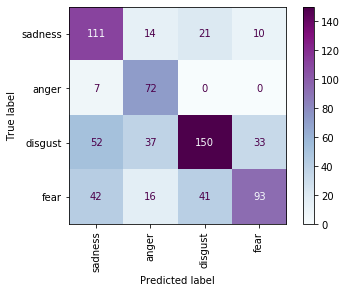

In [46]:
knn_model = KNeighborsClassifier(n_neighbors=3)
accs = []
reports = []
f1 = []
pr = []
re = []
pe = []

#javed#
accuracy_ = []
P_r_f = []

mean_accuracy= []
mean_p_r_f =[]
##javed###
roc_auc_ = []
roc_auc_one = []
roc_auc_two = []
roc_auc_three = []
roc_auc_four = []
st_time = time.time()
for train_index, test_index in skfold.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # Undersampling
    X_train_under, y_train_under = rus.fit_resample(X_train, y_train)
    predictions, accuracy, f1socre, precision, recall, alg_accuracy, alg_p_r_f_score = train_test_model(knn_model, X_train_under, X_test, y_train_under, y_test, labels)

    fpr_zero, tpr_zero, _ = roc_curve(y_test, knn_model.predict_proba(X_test)[:,1], pos_label=0)
    fpr_one, tpr_one, __ = roc_curve(y_test, knn_model.predict_proba(X_test)[:,1], pos_label=1)
    fpr_two, tpr_two, ___ = roc_curve(y_test, knn_model.predict_proba(X_test)[:,1], pos_label=2)
    fpr_three, tpr_three, ____ = roc_curve(y_test, knn_model.predict_proba(X_test)[:,1], pos_label=3)
    fpr_four, tpr_four, _____ = roc_curve(y_test, knn_model.predict_proba (X_test)[:,1], pos_label=4)

    roc_auc_.append(auc(fpr_zero, tpr_zero))
    roc_auc_one.append(auc(fpr_one, tpr_one))
    roc_auc_two.append(auc(fpr_two, tpr_two))
    roc_auc_three.append(auc(fpr_three, tpr_three))
    roc_auc_four.append(auc(fpr_four, tpr_four))
    
    #javed###      
    accuracy_.append(alg_accuracy)
    P_r_f.append(alg_p_r_f_score)
    #### jave ####

    pe.append(predictions)
    accs.append(accuracy)
    f1.append(f1socre)
    pr.append(precision)
    re.append(recall)


en_time = time.time()
#print('mean predictions: {:.2f} %'.format(sum(pe) / len(pe) ))
print('Total time: {:.2f}s'.format(en_time-st_time))   
print('mean accuracy: {:.2f} %'.format(np.mean(accs)))
print('mean f1 socre: {:.2f} %'.format(np.mean(f1)))
print('mean precision: {:.2f} %'.format(np.mean(pr)))
print('mean recall: {:.2f} %'.format(np.mean(re)))

roc_zero = sum(roc_auc_) / len(roc_auc_)
print("\nROC across folds for zero: ", roc_zero)

roc_one = sum(roc_auc_one) / len(roc_auc_one)
print("\nROC across folds for one: ", roc_one)

roc_two = sum(roc_auc_two) / len(roc_auc_two)
print("\nROC across folds for two: ", roc_two)

roc_three = sum(roc_auc_three) / len(roc_auc_three)
print("\nROC across folds for three: ", roc_three)

roc_four = sum(roc_auc_four) / len(roc_auc_four)
print("\nROC across folds for four: ", roc_four)

#### jave ####
mean_accuracy= np.mean(accuracy_, axis=0)
print("the average accuracy of KNN is",mean_accuracy)
    
mean_p_r_f=np.mean(P_r_f, axis=0)
print("the presion, recall, f are", mean_p_r_f)
#### jave ####

#print(fpr_zero)
#print(tpr_zero)

#print(metrics_report)
unique, counts = np.unique(y_train_res, return_counts=True)
print(list(zip(unique, counts)))
plot_confusion_matrix(knn_model, X_test, y_test, display_labels=labels, xticks_rotation='vertical', cmap="BuPu")

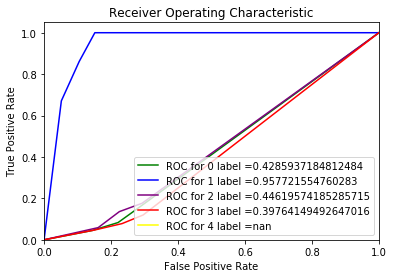

In [47]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_zero, tpr_zero, 'b', color='green', label= "ROC for 0 label =" +str(roc_zero))
plt.plot(fpr_one, tpr_one, 'b', label= "ROC for 1 label =" +str(roc_one))
plt.plot(fpr_two, tpr_two, 'b', color='purple',  label= "ROC for 2 label =" +str(roc_two))
plt.plot(fpr_three, tpr_three, 'b', color='red',  label= "ROC for 3 label =" +str(roc_three))
plt.plot(fpr_four, tpr_four, 'b', color='yellow', label= "ROC for 4 label =" +str(roc_four))
plt.legend(loc = 'lower right')
#plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### MLPClassifier

Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Total time: 866.55s
mean accuracy: 0.84 %
mean f1 socre: 0.84 %
mean precision: 0.84 %
mean recall: 0.84 %
the average accuracy of MLP is 0.8363966891477622
the presion, recall, f are [[  0.81294792   0.79011652   0.87107515   0.83785022]
 [  0.85786788   1.           0.78561867   0.82419581]
 [  0.83458373   0.88241937   0.82598983   0.83075982]
 [156.2         78.5        272.9        192.3       ]]
0.9458054182869942
[(0, 2457), (1, 2457), (2, 2457), (3, 2457)]


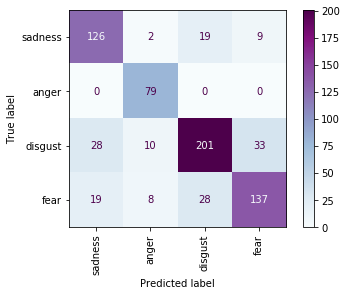

In [48]:
mlp_model = MLPClassifier(random_state=1, max_iter=300)
accs = []
reports = []
f1 = []
pr = []
re = []
pe = []

#javed#
accuracy_ = []
P_r_f = []

mean_accuracy= []
mean_p_r_f =[]
##javed###
roc_auc_ = []
roc_auc_one_under = []
roc_auc_two = []
roc_auc_three = []
roc_auc_four_mlp = []

tprs_zero_mlp_under = []
tprs_one_mlp_under = []
tprs_two_mlp_under = []
tprs_three_mlp_under = []
tprs_four_mlp_under = []

mean_fpr_mlp_under = np.linspace(0,1,100)

st_time = time.time()
for train_index, test_index in skfold.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # Undersampling
    #X_train_under, y_train_under = rus.fit_sample(X_train, y_train)
    predictions, accuracy, f1socre, precision, recall, alg_accuracy, alg_p_r_f_score = train_test_model(mlp_model, X_train_under, X_test, y_train_under, y_test, labels)

    #fpr_zero, tpr_zero, _ = roc_curve(y_test, mlp_model.predict_proba(X_test)[:,1], pos_label=0)
    #fpr_one_under, tpr_one_under, __ = roc_curve(y_test, mlp_model.predict_proba(X_test)[:,1], pos_label=1)
    #fpr_two, tpr_two, ___ = roc_curve(y_test, mlp_model.predict_proba(X_test)[:,1], pos_label=2)
    #fpr_three, tpr_three, ____ = roc_curve(y_test, mlp_model.predict_proba(X_test)[:,1], pos_label=3)
    fpr_four_mlp_under, tpr_four_mlp_under, _____ = roc_curve(y_test, mlp_model.predict_proba (X_test)[:,3], pos_label=3)

    tprs_four_mlp_under.append(interp(mean_fpr_mlp_under, fpr_four_mlp_under, tpr_four_mlp_under))
    
        #javed###      
    accuracy_.append(alg_accuracy)
    P_r_f.append(alg_p_r_f_score)
    #### jave ####
    
    #roc_auc_one = (auc(fpr_zero, tpr_zero))
    #roc_auc_one = (auc(fpr_one, tpr_one))
    #roc_auc_two = (auc(fpr_two, tpr_two))
    #roc_auc_three = (auc(fpr_three, tpr_three))
    #roc_auc_four = (auc(fpr_four_mlp_under, tpr_four_mlp_under))

    pe.append(predictions)
    accs.append(accuracy)
    f1.append(f1socre)
    pr.append(precision)
    re.append(recall)


en_time = time.time()
#print('mean predictions: {:.2f} %'.format(sum(pe) / len(pe) ))
print('Total time: {:.2f}s'.format(en_time-st_time))   
print('mean accuracy: {:.2f} %'.format(np.mean(accs)))
print('mean f1 socre: {:.2f} %'.format(np.mean(f1)))
print('mean precision: {:.2f} %'.format(np.mean(pr)))
print('mean recall: {:.2f} %'.format(np.mean(re)))

#roc_zero = sum(roc_auc_) / len(roc_auc_)
#print("\nROC across folds for zero: ", roc_zero)

#roc_mlp_under = sum(roc_auc_one_under) / len(roc_auc_one_under)
#print("\nROC across folds for one: ", roc_mlp_under)

#roc_two = sum(roc_auc_two) / len(roc_auc_two)
#print("\nROC across folds for two: ", roc_two)

#roc_three = sum(roc_auc_three) / len(roc_auc_three)
#print("\nROC across folds for three: ", roc_three)

#roc_mlp_under_four = sum(roc_auc_four_mlp) / len(roc_auc_four_mlp)
#print("\nROC across folds for four: ", roc_mlp_under_four)

mean_tpr_mlp_under = np.mean(tprs_four_mlp_under, axis=0)
mean_auc_mlp_under = auc(mean_fpr_mlp_under, mean_tpr_mlp_under)

#### jave ####
mean_accuracy= np.mean(accuracy_, axis=0)
print("the average accuracy of MLP is",mean_accuracy)
    
mean_p_r_f=np.mean(P_r_f, axis=0)
print("the presion, recall, f are", mean_p_r_f)
#### jave ####

#print(mean_tpr_mlp_under)
#print(mean_fpr_mlp_under)
print(mean_auc_mlp_under)

#print(metrics_report)
unique, counts = np.unique(y_train_res, return_counts=True)
print(list(zip(unique, counts)))
plot_confusion_matrix(mlp_model, X_test, y_test, display_labels=labels, xticks_rotation='vertical', cmap="BuPu")

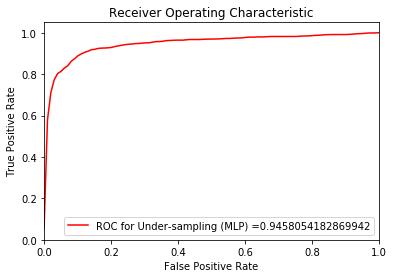

In [49]:
plt.title('Receiver Operating Characteristic')
#plt.plot(fpr_one_under, tpr_one_under, 'b', label= "Under-sampling =" +str(roc_mlp_under))
#plt.plot(fpr_zero, tpr_zero, 'b', color='green', label= "ROC for 0 label =" +str(roc_zero))
#plt.plot(fpr_one, tpr_one, 'b', label= "ROC for 1 label =" +str(roc_one))
#plt.plot(fpr_two, tpr_two, 'b', color='purple',  label= "ROC for 2 label =" +str(roc_two))
#plt.plot(fpr_three, tpr_three, 'b', color='red',  label= "ROC for 3 label =" +str(roc_three))
plt.plot(mean_fpr_mlp_under, mean_tpr_mlp_under, 'b', color='red', label= "ROC for Under-sampling (MLP) =" +str(mean_auc_mlp_under))
plt.legend(loc = 'lower right')
#plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Gradient Boosting Classifier

Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Total time: 56.64s
mean accuracy: 0.75 %
mean f1 socre: 0.75 %
mean precision: 0.75 %
mean recall: 0.75 %

ROC across folds for zero:  0.3164756310544753

ROC across folds for one:  0.962245697590037

ROC across folds for two:  0.5450220252035239

ROC across folds for three:  0.3749258142434158

ROC across folds for four:  nan
the average accuracy of GBC is 0.7473879010831801
the presion, recall, f are [[  0.77501315   0.67578017   0.72752104   0.80653895]
 [  0.74714192   0.90451152   0.74861829   0.68173035]
 [  0.76047064   0.77315001   0.73

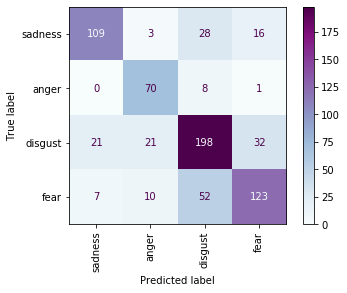

In [50]:
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)

accs = []
reports = []
f1 = []
pr = []
re = []
pe = []

#javed#
accuracy_ = []
P_r_f = []

mean_accuracy= []
mean_p_r_f =[]
##javed###

roc_auc_ = []
roc_auc_one = []
roc_auc_two = []
roc_auc_three = []
roc_auc_four = []
st_time = time.time()
for train_index, test_index in skfold.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # Undersampling
    #X_train_under, y_train_under = rus.fit_sample(X_train, y_train)
    predictions, accuracy, f1socre, precision, recall, alg_accuracy, alg_p_r_f_score = train_test_model(gb_model, X_train_under, X_test, y_train_under, y_test, labels)

    fpr_zero, tpr_zero, _ = roc_curve(y_test, gb_model.predict_proba(X_test)[:,1], pos_label=0)
    fpr_one, tpr_one, __ = roc_curve(y_test, gb_model.predict_proba(X_test)[:,1], pos_label=1)
    fpr_two, tpr_two, ___ = roc_curve(y_test, gb_model.predict_proba(X_test)[:,1], pos_label=2)
    fpr_three, tpr_three, ____ = roc_curve(y_test, gb_model.predict_proba(X_test)[:,1], pos_label=3)
    fpr_four, tpr_four, _____ = roc_curve(y_test, gb_model.predict_proba (X_test)[:,1], pos_label=4)

    roc_auc_.append(auc(fpr_zero, tpr_zero))
    roc_auc_one.append(auc(fpr_one, tpr_one))
    roc_auc_two.append(auc(fpr_two, tpr_two))
    roc_auc_three.append(auc(fpr_three, tpr_three))
    roc_auc_four.append(auc(fpr_four, tpr_four))
    
            #javed###      
    accuracy_.append(alg_accuracy)
    P_r_f.append(alg_p_r_f_score)
    #### jave ####

    pe.append(predictions)
    accs.append(accuracy)
    f1.append(f1socre)
    pr.append(precision)
    re.append(recall)


en_time = time.time()
#print('mean predictions: {:.2f} %'.format(sum(pe) / len(pe) ))
print('Total time: {:.2f}s'.format(en_time-st_time))   
print('mean accuracy: {:.2f} %'.format(np.mean(accs)))
print('mean f1 socre: {:.2f} %'.format(np.mean(f1)))
print('mean precision: {:.2f} %'.format(np.mean(pr)))
print('mean recall: {:.2f} %'.format(np.mean(re)))

roc_zero = sum(roc_auc_) / len(roc_auc_)
print("\nROC across folds for zero: ", roc_zero)

roc_one = sum(roc_auc_one) / len(roc_auc_one)
print("\nROC across folds for one: ", roc_one)

roc_two = sum(roc_auc_two) / len(roc_auc_two)
print("\nROC across folds for two: ", roc_two)

roc_three = sum(roc_auc_three) / len(roc_auc_three)
print("\nROC across folds for three: ", roc_three)

roc_four = sum(roc_auc_four) / len(roc_auc_four)
print("\nROC across folds for four: ", roc_four)

#### jave ####
mean_accuracy= np.mean(accuracy_, axis=0)
print("the average accuracy of GBC is",mean_accuracy)
    
mean_p_r_f=np.mean(P_r_f, axis=0)
print("the presion, recall, f are", mean_p_r_f)
#### jave ####

#print(fpr_zero)
#print(tpr_zero)

#print(metrics_report)
unique, counts = np.unique(y_train_res, return_counts=True)
print(list(zip(unique, counts)))
plot_confusion_matrix(gb_model, X_test, y_test, display_labels=labels, xticks_rotation='vertical', cmap="BuPu")

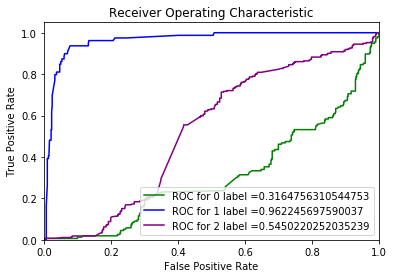

In [51]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_zero, tpr_zero, 'b', color='green', label= "ROC for 0 label =" +str(roc_zero))
plt.plot(fpr_one, tpr_one, 'b', label= "ROC for 1 label =" +str(roc_one))
plt.plot(fpr_two, tpr_two, 'b', color='purple',  label= "ROC for 2 label =" +str(roc_two))
#plt.plot(fpr_three, tpr_three, 'b', color='red',  label= "ROC for 3 label =" +str(roc_three))
#plt.plot(fpr_four, tpr_four, 'b', color='yellow', label= "ROC for 4 label =" +str(roc_four))
plt.legend(loc = 'lower right')
#plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Ensemble Methods
Ensemble methods are techniques that create multiple models and then combine them to produce improved results.

### Voting Classifier

Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Total time: 24.69s
mean accuracy: 0.83 %
mean f1 socre: 0.83 %
mean precision: 0.83 %
mean recall: 0.83 %
the average accuracy of Voting Classifier is 0.8266807684447169
the presion, recall, f are [[  0.78876018   0.74643371   0.87865263   0.84142053]
 [  0.83734281   0.99745213   0.77351864   0.82368307]
 [  0.8119987    0.85311098   0.8225064    0.83209135]
 [156.2         78.5        272.9        192.3       ]]
[(0, 706), (1, 706), (2, 706), (3, 706)]


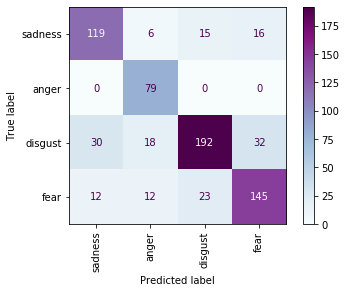

In [52]:
nb_model = MultinomialNB()
rf_model = RandomForestClassifier(n_estimators=100, max_depth=100, min_samples_split=10, n_jobs=-1, verbose=0)
log_model = LogisticRegression(penalty='l2', max_iter=500)

vote_model = VotingClassifier(estimators=[('nb', nb_model), ('rf', rf_model), ('log', log_model)], voting='hard')

accs = []
reports = []
f1 = []
pr = []
re =[]
#javed#
accuracy_ = []
P_r_f = []

mean_accuracy= []
mean_p_r_f =[]
##javed###

st_time = time.time()

for train_index, test_index in skfold.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # Undersampling
    #X_train_under, y_train_under = rus.fit_sample(X_train, y_train)
    predictions, accuracy, f1socre, precision, recall, alg_accuracy, alg_p_r_f_score = train_test_model(vote_model, X_train_under, X_test, y_train_under, y_test, labels)
    accs.append(accuracy)
    f1.append(f1socre)
    pr.append(precision)
    re.append(recall)
    #reports.append(metrics_report)
    
                #javed###      
    accuracy_.append(alg_accuracy)
    P_r_f.append(alg_p_r_f_score)
    #### jave ####
    
en_time = time.time()
print('Total time: {:.2f}s'.format(en_time-st_time))   
print('mean accuracy: {:.2f} %'.format(np.mean(accs)))
print('mean f1 socre: {:.2f} %'.format(np.mean(f1)))
print('mean precision: {:.2f} %'.format(np.mean(pr)))
print('mean recall: {:.2f} %'.format(np.mean(re)))


#### jave ####
mean_accuracy= np.mean(accuracy_, axis=0)
print("the average accuracy of Voting Classifier is",mean_accuracy)
    
mean_p_r_f=np.mean(P_r_f, axis=0)
print("the presion, recall, f are", mean_p_r_f)
#### jave ####


unique, counts = np.unique(y_train_under, return_counts=True)
print(list(zip(unique, counts)))
plot_confusion_matrix(vote_model, X_test, y_test, display_labels=labels, xticks_rotation='vertical', cmap="BuPu")

### Ada Boost Classifier
The core principle of AdaBoost is to fit a sequence of weak learners (i.e., models that are only slightly better than random guessing, such as small decision trees) on repeatedly modified versions of the data.

Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Total time: 110.44s
mean accuracy: 0.59 %
mean f1 socre: 0.60 %
mean precision: 0.59 %
mean recall: 0.59 %
the average accuracy of AdaBoost is 0.5907982832618025
the presion, recall, f are [[  0.50148781   0.61985329   0.62270617   0.63730728]
 [  0.63697942   0.8103051    0.53646843   0.54075723]
 [  0.5608143    0.7021739    0.57590236   0.58433916]
 [156.2         78.5        272.9        192.3       ]]
[(0, 706), (1, 706), (2, 706), (3, 706)]


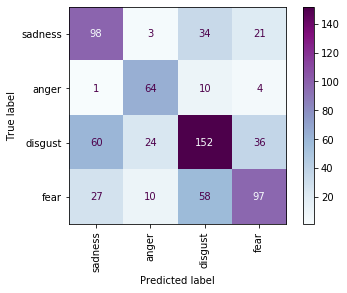

In [53]:
ada_model = AdaBoostClassifier(n_estimators=500)

accs = []
reports = []
f1 = []
pr = []
re =[]

#javed#
accuracy_ = []
P_r_f = []

mean_accuracy= []
mean_p_r_f =[]
##javed###
st_time = time.time()

for train_index, test_index in skfold.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # Undersampling
    #X_train_under, y_train_under = rus.fit_sample(X_train, y_train)
    predictions, accuracy, f1socre, precision, recall, alg_accuracy, alg_p_r_f_score = train_test_model(ada_model, X_train_under, X_test, y_train_under, y_test, labels)
    accs.append(accuracy)
    f1.append(f1socre)
    pr.append(precision)
    re.append(recall)
    #reports.append(metrics_report)
    
    #javed###      
    accuracy_.append(alg_accuracy)
    P_r_f.append(alg_p_r_f_score)
    #### jave ####
    
    
en_time = time.time()
print('Total time: {:.2f}s'.format(en_time-st_time))   
print('mean accuracy: {:.2f} %'.format(np.mean(accs)))
print('mean f1 socre: {:.2f} %'.format(np.mean(f1)))
print('mean precision: {:.2f} %'.format(np.mean(pr)))
print('mean recall: {:.2f} %'.format(np.mean(re)))

#### jave ####
mean_accuracy= np.mean(accuracy_, axis=0)
print("the average accuracy of AdaBoost is",mean_accuracy)
    
mean_p_r_f=np.mean(P_r_f, axis=0)
print("the presion, recall, f are", mean_p_r_f)
#### jave ####
unique, counts = np.unique(y_train_under, return_counts=True)
print(list(zip(unique, counts)))
plot_confusion_matrix(ada_model, X_test, y_test, display_labels=labels, xticks_rotation='vertical', cmap="BuPu")

# ROC Combine

### ROC for Random Forest

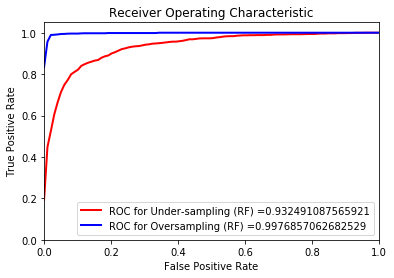

In [54]:
plt.title('Receiver Operating Characteristic')
plt.plot(mean_fpr_rf_under, mean_tpr_rf_under, 'b', color='red', label= "ROC for Under-sampling (RF) =" +str(mean_auc_rf_under),lw=2, alpha=1)
plt.plot(mean_fpr_rf, mean_tpr_rf, 'b', label= "ROC for Oversampling (RF) =" +str(mean_auc_rf),lw=2, alpha=1)
plt.legend(loc = 'lower right')
#plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### ROC for MLP

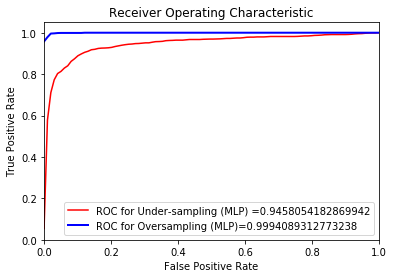

In [55]:
plt.title('Receiver Operating Characteristic')
plt.plot(mean_fpr_mlp_under, mean_tpr_mlp_under, 'b', color='red', label= "ROC for Under-sampling (MLP) =" +str(mean_auc_mlp_under))
plt.plot(mean_fpr_mlp, mean_tpr_mlp, 'b', label= "ROC for Oversampling (MLP)=" +str(mean_auc_mlp),lw=2, alpha=1)
plt.legend(loc = 'lower right')
#plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### ROC for SVM

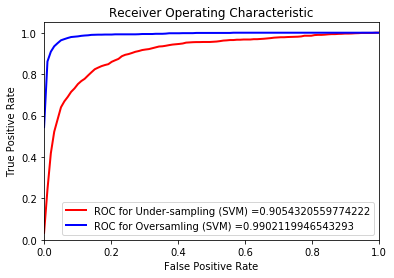

In [56]:
plt.title('Receiver Operating Characteristic')
plt.plot(mean_fpr_svm_under, mean_tpr_svm_under, 'b', color='red', label= "ROC for Under-sampling (SVM) =" +str(mean_auc_svm_under) ,lw=2, alpha=1)
plt.plot(mean_fpr_svm, mean_tpr_svm, 'b', label= "ROC for Oversamling (SVM) =" +str(mean_auc_svm),lw=2, alpha=1)
plt.legend(loc = 'lower right')
#plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()